# Amount Organization Study for WabiSabi based CoinJoins

This notebook explores some possibilities for structuring WabiSabi CoinJoin transactions. It is not intended to be normative, definitive or authoritative, at least not at this point. Theoretical justifications are mostly elsewhere, but I tried to give a brief summary for most of the ideas, please pester me for more details if something is unclear.

## Problem Definition

WabiSabi credentials allow participants to collaborate on a CoinJoin transaction. The server gathers inputs and outputs, and can ensure that output amounts are covered by input amounts without revealing anything about which inputs covered the costs of which outputs to the coordinator or the other participants.

Although the credential system supports arbitrary amounts, creating outputs with arbitrary amounts privately is not a simple undertaking. This is because the resulting transaction is still a Bitcoin transaction with transparent amounts, and these may reveal information about links between inputs and outputs, undoing the privacy benefit provided by the unlinkability property of the anonymous credentials used to construct the transaction.

## Value Proposition of CoinJoin Transactions

Normally the utility of Bitcoin transactions to users is to be able to move value between users, i.e. send and receive payments. The utility of non-transfer transactions is limited to the extend that they support transfer transactions, since only the latter kind creates value by facilitating trade. Therefore when users participate in CoinJoin transactions spending to themselves, the utility of these transactions purchased with the mining fees is the improved privacy in the transactions that actually transfer value.

Privacy in Bitcoin means being able to receive arbitrary amounts and obscure the flow of funds from the sender, and to be able to send arbitrary amounts with those funds, but without revealing their origin. This is difficult because the amounts and the transaction graph are transparent. Outputs of CoinJoin transactions can gain privacy when their containing transaction can be interpreted in multiple ways and it's not clear how to link inputs to outputs.

In JoinMarket the taker pays both mining fees and maker fees in exchange for the knowledge that by choosing and coordinating between the makers, only they know the links between inputs and outputs (assuming the makers are not colluding or sybils). Since sybil attacks as a maker are profitable, fidelity bonds have been introduced, imposing a (time value) cost on makers, which gives stronger assurances to takers that if the makers are not distinct entities then the entity behind them must have sacrificed a significant amount of liquidity, thereby making such an attack expensive.

In the centralized setting every user pays only for their own inputs and outputs. As a result so the cost for each user is lower compared to taker fees, and the threat of spying by sybil attack by other users is lower compared to with makers without fidelity bonds as there is no profit. The mining fees paid by the other users and knowledge that the transaction was coordinated privately are ultimately what provides utility to the participants. Any coordination fees can of course be used by the coordinator to perform a sybil attack at a reduced cost just as with makers in JoinMarket, so those should not be taken into account as a deterrent, but the mining fees are an unforgeable cost imposed on a spying adversary whether it is colluding with the coordinator or not.

The centralized setting provides ample opportunity for positive sum outcomes. When constructed appropriately, larger transactions can provide better cost effectiveness with regards to privacy because total cost of a sybiled transaction must also include any surrounding transactions required to keep the attack plausibly deniable. This cost can quickly dwarves the fees paid by each individual user, which makes a targetted attack against them cost prohibitive. If an adversary attempts to reduce this cost by attacking multiple users at once the effectiveness of the attack rapidly decreases with the number of honest users.

There is also opportunity for users with different time or privacy preferences complement each other through mechanism design. In particular, users with higher privacy requirements with a low time preference can be incentivized to mix repeatedly with users that have a higher time preference and which would enjoy counterparties to the mix.

Another way to improve the cost effectiveness of CoinJoin transactions is to use them directly for transfers, instead of only self spends. This requires privacy for arbitrary amounts. By spending from a CoinJoin transaction directly to a recipient's address, if the payment amount is sufficiently ambiguous within the transaction privacy can be preserved with a smaller blockspace requirement. JoinMarket supports this for both takers and makers.

Better yet is the cooperative case where a sender and receiver both participating in the same CoinJoin transaction, each with their own (private) input amounts. Using credentials users can transfer value in a CoinJoin transaction while maintaining privacy from each other and the rest of the world, while also calling into question the validity of various heuristics used to analyze CoinJoin transactions by amount, in a similar way that PayJoin do.

## Goal

Based on the above value proposition, the coordinator's job is help users to pay mining fees together in a way that only the individual users know how to map their own inputs and outputs, and the transaction as a whole is ambiguous. The degree of ambiguity can vary, but ideally for every output amount there will be at least some ambiguity, that is more than one way of explaining how the output was funded by some combination of input amounts.

The goal of this study is to attempt to find a strategy for participation in CoinJoins based on WabiSabi credentials thereby that is compatible with the value proposition laid out above. By focusing on the potential for positive sum outcomes through incentive compatibility the hope is to find a Pareto efficient approach to constructing CoinJoins that is convincing enough to establish something resembling a Schelling point.

There are many questions to address and the design space is huge. Because protocol upgrades are hard and software needs incremental improvements, it would be best to keep the protocol as simple as possible and do as much as possible on the client side. To ensure positive sum outcomes and avoid fingerprinting some behaviours need to be consistent for all clients, damaging privacy when changed in upgrades, especially if users upgrade slowly. Finally, some tweaks and improvements as well as runtime parameters can vary between users based on their threat model and individual utility.

To approach the questions about what client behaviour should in a logical order we aim to answer them in the following order, more or less:

1. behaviours must be the same for all users, requiring major releases which may break compatibility to improve,
2. behaviours that should be the same for all users, can be improved iteratively after release
3. behaviours which can be parameterized by individual user preferences

Care must still be taken to ensure that allowing client diversity or leaving some alternatives unexplored should not result in loss of privacy, so some aspects of user parameterizable behaviour might need to be addressed before the release, but for the most part questions like which optimizer strategy is best for minimizing cost are ones where incremental improvements on the answers can be obtained afterwards.

## Working Assumptions

Tcoordinator imposes no special constraints on input and output registrations. However, additional constraints may be added later if necessary or desirable without much complication, for example minimum input requirements on some transactions would allow users with larger amounts to find each other more easily, and the coordinator can also constrain the registered amounts (inputs as well as outputs) in order to provide stronger assurances for the ambiguity. In the simplest scenario any outcome that can be achieved by making a transaction on your own should possible as part of a CoinJoin transaction in principle, and unless a good reason arises we should not rely on removal of this flexibility at the protocol level.

There exists some arbitrary set of standard denominations is known by all users. This set should be sparse in the range of the amounts that can be used. Equal amount outputs whose values are drawn from this set form the foundation for privacy with which we aim to support arbitrary amounts.

The number of [non-derived sub-transactions](](https://sci-hub.se/https://ieeexplore.ieee.org/abstract/document/8029483)) is a limiting constraint on the anonymity set size of any output (standard or arbitrary amount), and threrefore the privacy provided by the transaction. Another constraint is the (unobservable) number of other participants and the anonymity set sizes of their inputs, which in turn is bounded by `min(len(inputs), len(outputs))`. Although the latter is not under the user's control, the choice of output amounts does affect the former.

When the actions of individual users agree the privacy of all users' outputs improves on average because the average number of non-derived sub-transactions per output can grow exponentially (albeit with [diminishing returns](https://en.wikipedia.org/wiki/Liebig%27s_law_of_the_minimum), since it's only one of several relevant lower bounds). Conversely, since with every de-anonymized user the overall privacy can also diminish exponentially, so a healthy safety margin is in order for this limiting constraint. Exponential growth is more likely when trivial equivalence relations between non-derived sub-transactions are given by equal amount outputs, so the actions of individual users "agreeing" means there are sufficiently many equal amount outputs and that the amounts are related in such a way that their combinatorics creates a large degree of ambiguity.

For this to work the server must announce the (possibly monotonically growing) set of the input (and optionally output) registrations. In the simplest case the coordinator must broadcast ownership proofs from the registered inputs to all participants before output registration starts. This is necessary to ensure that the credentials were all issued with the same parameters, a requirement for unlinkability. For full nodes this is sufficient information to verify input amounts and spend status. With Merkle inclusion proofs light clients can verify the former but not the latter.

With knowledge of the other users amounts, and the knowledge that other users also know this, participants can improve the likelyhood of (or with dynamic updated information about about output registrations, guaranteee) a sufficiently high lower bound on the number of sub-transactions for the outputs they choose to register. 

Finally, keeping this restricted set mostly consistent between transactions provides: when users mix repeatedly especially over longer periods time period, in the best case the ambiguity per output can compound by [inheritance](https://medium.com/samourai-wallet/diving-head-first-into-whirlpool-anonymity-sets-4156a54b0bc7) logistically instead of linearly in the number of transactions of the user, since the inherited ambiguity is potentially bounded by the width of the mixing graph as a whole in those circumstances and not only the counterparties to each individual transaction.

## Some Example Amounts

Let's first look at some input amounts [provided by nopara73](https://github.com/nopara73/Dumplings). This is a sample of "fresh" (not outputs of Wasabi CoinJoins, but possibly change from post-mix payments) input amounts.

In [1]:
import pandas as pd
wasabi_amounts = pd.read_csv("wasabi_amounts.csv", header=None, names=("amount",))
wasabi_amounts['sats'] = (1e8*wasabi_amounts['amount']).astype(int)

In [2]:
wasabi_amounts.describe()

,amount,sats
count,8000.000000,8.000000e+03
mean,0.359992,3.599917e+07
std,2.060168,2.060168e+08
min,0.000057,5.736000e+03
25%,0.018764,1.876399e+06
50%,0.055060,5.506016e+06
75%,0.127704,1.277041e+07
max,94.053521,9.405352e+09


Plotting a histogram of the logarithms of the amounts shows the distribution of values over several orders of magnitude clearly enough so that we can see a rough bell curve background with a few pronounced peaks, in particular within a small region of 0.1 btc.

In [3]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (9, 6)
matplotlib.rcParams['figure.max_open_warning'] = 100

<IPython.core.display.Javascript object>


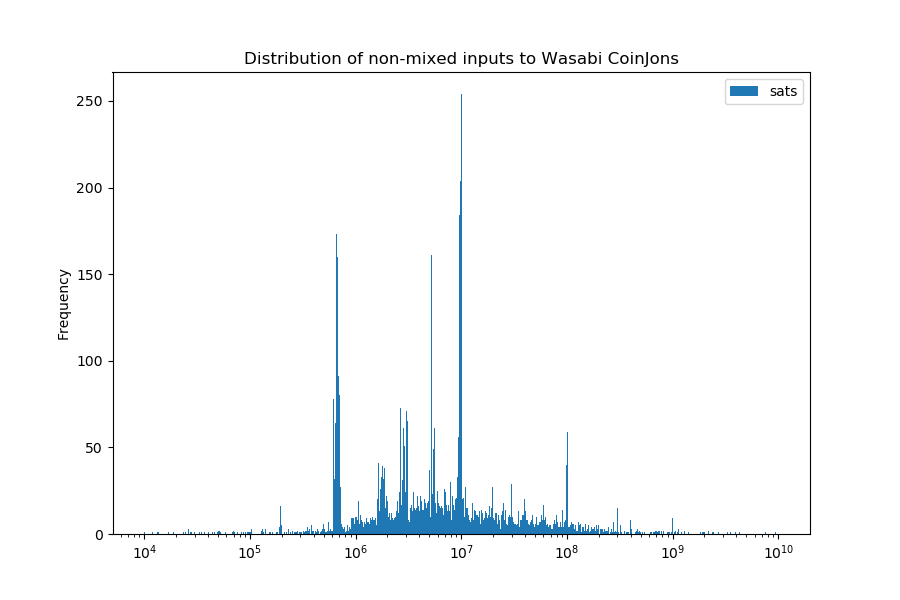

In [4]:
wasabi_amounts['sats'].plot.hist(bins=np.logspace(4,10,1024), legend=True, logx=True, title="Distribution of non-mixed inputs to Wasabi CoinJons")

Benford's law seems to hold initially but breaks down for the larger digits.

In [5]:
import math

def first_digit(n : int) -> int:
    while n >= 10:
        n = int(n / 10)
    return n

def plot_first_digits(series, title="Distribution of First Digit"):
    fig = plt.figure()
    count = series.count()
    plt.plot(range(0,9), [ count * math.log10(1+1/x) for x in range(1,10)], "r-", label="Benford's Law")
    pd.Series(series.map(first_digit), name='first digit').value_counts().sort_index().plot.bar(title=title)
    fig.legend()
    plt.show()

<IPython.core.display.Javascript object>


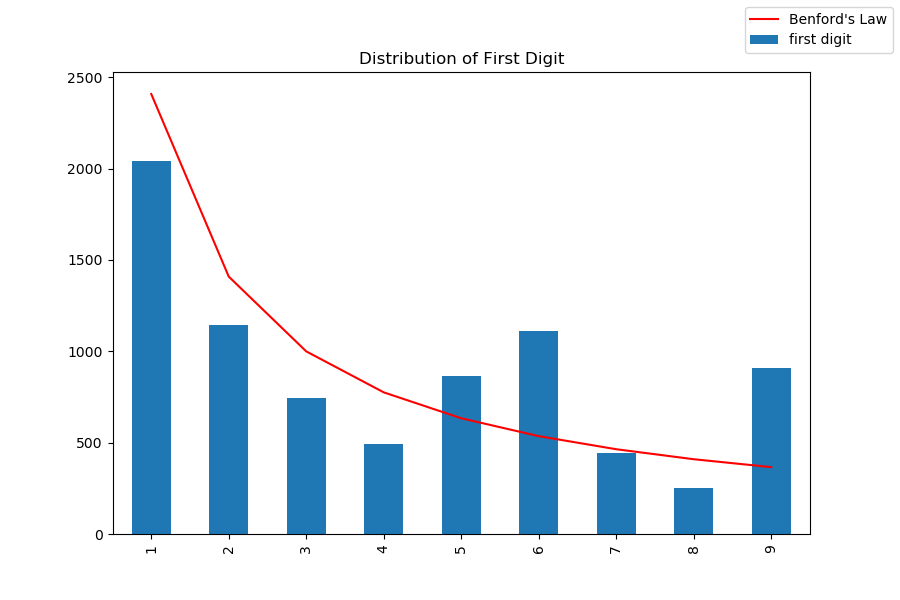

In [6]:
plot_first_digits(wasabi_amounts['sats'])

Perhaps this is change from spending of mixed coins being remixed, because the distribution appears to match more closely when filtering out values smaller than 0.1 BTC.

<IPython.core.display.Javascript object>


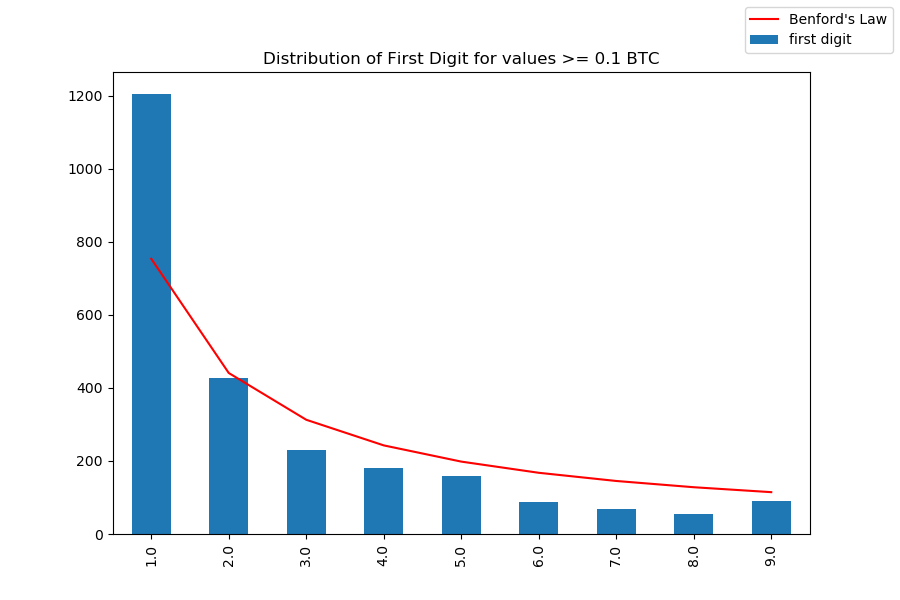

In [7]:
# TODO why does the value_counts count these as floats when the filter is applied?
plot_first_digits(wasabi_amounts['sats'].where(lambda x: x >= 1e7), title="Distribution of First Digit for values >= 0.1 BTC")

Since Wasabi uses ~0.1 BTC as its base denomination and ~0.2 is the next common multiple, an over-representation of inputs close to that is reasonable to expect. This appears to persist for larger threshold values as well. Note, however, Benford's law is not expected to hold unless the data spans multiple orders of magnitude, which is perhaps a bit of a reach above 0.1 BTC:

In [8]:
pd.DataFrame(wasabi_amounts['sats'].where(lambda x: x >= 1e7).map(np.log10)).describe()

,sats
count,2504.000000
mean,7.585387
std,0.512129
min,7.000000
25%,7.171760
50%,7.476482
75%,7.903244
max,9.973375


This seems to suggest that apart from the obvious bias towards Wasabi's current ~0.1 BTC denomination and a slight bias towards round amounts, the input values appear to be more or less randomly distributed.

## Amount Weights

Because amounts in CoinJoin transactions can reveal information about links between inputs and outputs, we want to look at the representations of numerical values from the range of possible input balances users may have in as sums of values from a small subset of the range.

[Positional notation](https://en.wikipedia.org/wiki/Positional_notation) is a logical starting point for choosing such subsets because the size of the set of values used is logarithmic in the range of the possible input values that can be represented using their members. We can use the [Hamming weight](https://en.wikipedia.org/wiki/Hamming_weight) of satoshi amounts in various bases as a benchmark to compare against.

Based therefore given an  we can quantify the number of outputs that would be required to decompose an arbitrary input balance (the sum of the inputs minus the any fees taken into account).

When the cost per output is 0 and no dust threshold is used, the following functions all return the Hamming weight (just more slowly). When but when non-zero values are used the resulting weights deviate, and instead of returning the Hamming weight per se they give the estimated number of minimal Hamming weight transaction outputs required to decompose the given amount.

This is done by subtracting the cost per output remaining amount after each successive digit. An alternative approach would be - assuming decimal values as an example and a cost of `100` satoshis per output -- decompose e.g. `0.00012000` into `0.00009900` and `0.00000900` (`0.00010000 - 100` and `0.00001000 - 100`), but these functions simulate decomposition of the amount `0.00012000` into `0.00010000`, and then decompose the remaining `1900` sats into `0.00001000`, leaving 800 sats, etc, in an iterative approach. Note that this is symmetric (either the input side or the output side of a transaction must account for the fees), so the choice appears arbitrary (TODO verify this claim)

The dust threshold determines when the decomposition stops - with a nonzero value the least significant digits may be dropped, resulting in a lower final weight. The cost per output determines the overhead of the decomposition, resulting in hamming weight transitions shifting.

### Binary

The simplest Hamming weight is in unary - it's just the identity function. The second simplest is for binary, also known as the population count or popcount, how many 1 bits does the number have when written down in binary. We calculate it iteratively from the most significant to the least significant bit in order to be able to account for the overheads and rounding:

In [9]:
 def popcount(amount : int, dust_threshold : int = 0, cost_per_output : int = 0) -> int:
    weight = 0
    remaining = amount
    
    # start with a large power of 2
    denom = 1 << 50

    # account for the cost of the first output
    remaining -= cost_per_output
    
    while remaining > dust_threshold:
        # find the largest power of two that we can subtract
        while denom > remaining:
            denom = denom >> 1
        
        if denom == 0 or denom < dust_threshold:
            return weight
        
        remaining -= denom + cost_per_output
        weight += 1
        
    return weight

With both optional arguments omitted, `popcount` just returns the normal popcount:

In [10]:
pd.DataFrame([ (bin(i)[2:], popcount(i)) for i in range(0, 10) ], columns=['bits', 'popcount'])

,bits,popcount
0,0,0
1,1,1
2,10,1
3,11,2
4,100,1
5,101,2
6,110,2
7,111,3
8,1000,1
9,1001,2


In [11]:
assert(1 == popcount(1))
assert(1 == popcount(2))
assert(2 == popcount(3))
assert(3 == popcount(7))
assert(1 == popcount(1024))
assert(4 == popcount(1024 + 7))

Let's look at a plot of this function. In particular, notice how the are abrupt jumps back to a popcount of 1 at every power of 2. The implication is that subtracting a small amount (e.g. fees) from a large low popcount amount will result in a high popcount amount.

<IPython.core.display.Javascript object>


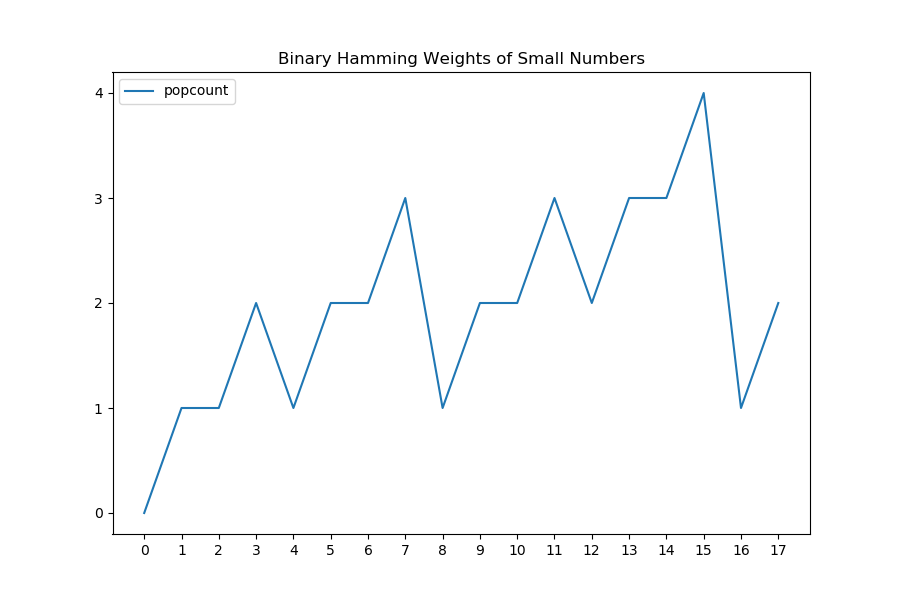

<IPython.core.display.Javascript object>


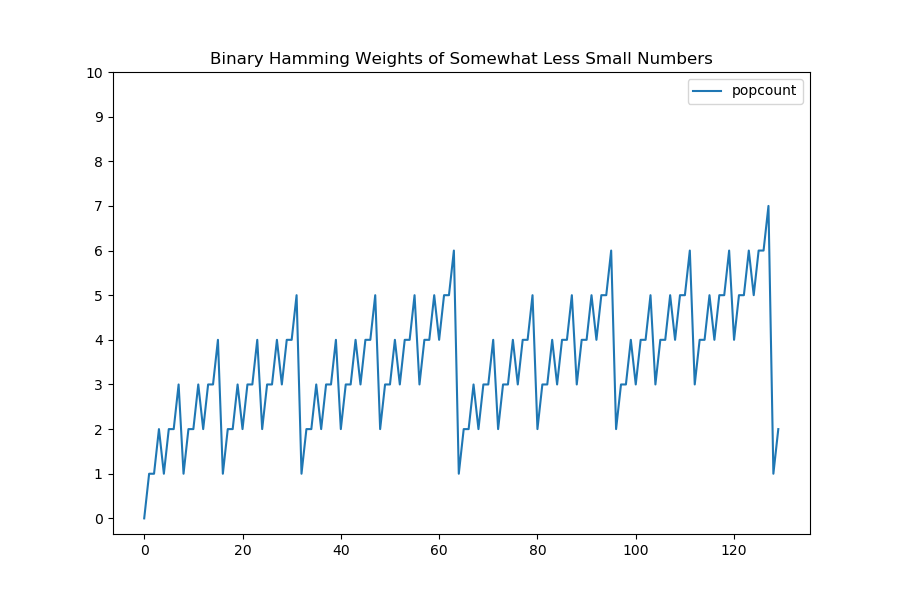

In [12]:
pd.DataFrame(map(popcount, range(0, 18)), columns=['popcount']).plot(xticks=range(0,18), yticks=range(0, 5), title="Binary Hamming Weights of Small Numbers")

pd.DataFrame(map(popcount, range(0, 130)), columns=['popcount']).plot(yticks=range(0,11), title="Binary Hamming Weights of Somewhat Less Small Numbers")

With a cost of `1` sat per output, we can output `1024 + 4`, for a combined realized weight of `2`, and `1` satoshi lost.

In [13]:
assert(2 == popcount(1024 + 7, dust_threshold = 0, cost_per_output = 1))

With a higher per output cost, we can't afford that, and can only output `1024 + 2`, again with `1` sat lost:

In [14]:
assert(2 == popcount(1024 + 7, dust_threshold = 0, cost_per_output = 2))

Here you can see the effect of subtracting (unrealistically) small fee amounts: as the fees increase the sudden drops in popcount shift to the right:

<IPython.core.display.Javascript object>


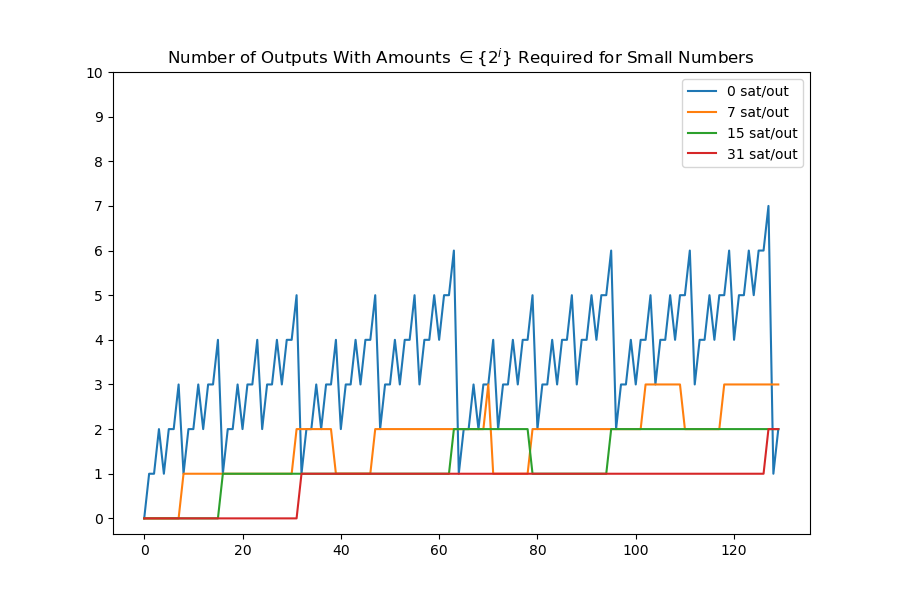

In [15]:
pd.DataFrame([ [ popcount(i, cost_per_output=cost) for cost in (0, 7, 15, 31) ] for i in range(0, 130) ], columns=['0 sat/out', '7 sat/out', '15 sat/out', '31 sat/out']).plot(yticks=range(0,11), title="Number of Outputs With Amounts $\in \{ 2^i \}$ Required for Small Numbers")

Setting the dust threshold to `3` (anything smaller than the threshold is considered dust), we can round off the second value, emitting only `1024`, so the weight is 1:

In [16]:
assert(1 == popcount(1024 + 7, dust_threshold = 3, cost_per_output = 2))

But we still get `1024 + 4` with more outputs with `0` per output costs:

In [17]:
assert(2 == popcount(1024 + 7, dust_threshold = 3, cost_per_output = 0))

Note how the cost per output implicitly sets a dust threshold, but the dust threshold on its own does not shift the transitions around, it only lowers the overall weight.

<IPython.core.display.Javascript object>


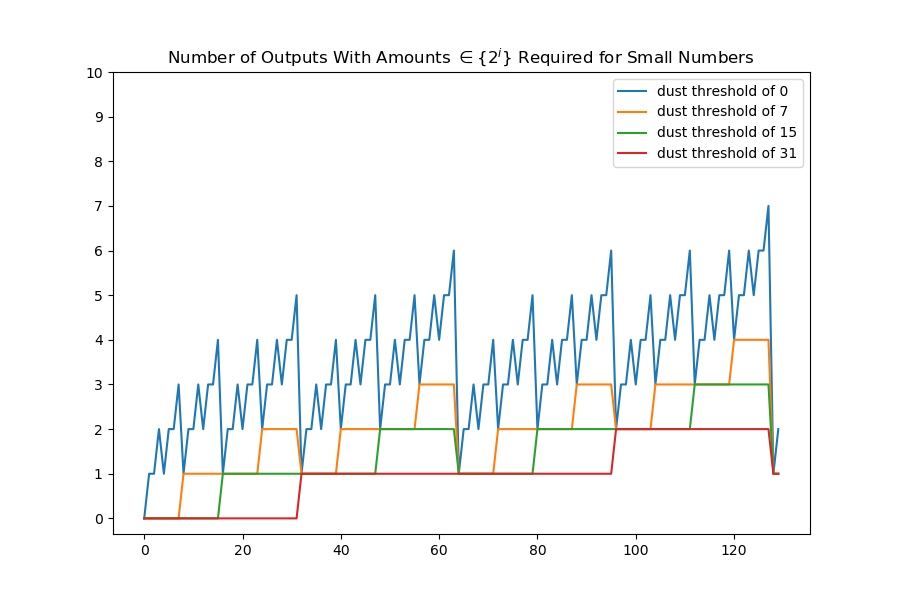

In [18]:
pd.DataFrame([ [ popcount(i, dust_threshold=dust) for dust in (0, 7, 15, 31) ] for i in range(0, 130) ], columns=['dust threshold of 0', 'dust threshold of 7',  'dust threshold of 15', 'dust threshold of 31']).plot(yticks=range(0,11), title="Number of Outputs With Amounts $\in \{ 2^i \}$ Required for Small Numbers")

### Decimal and Ternary

Next we'll generalize this approach to other bases:

In [19]:
# just a generalization of popcount to different bases
def hamming_weight(base : int, amount : int, dust_threshold : int = 0, cost_per_output : int = 0) -> int:
    weight = 0
    remaining = amount
    
    p = base ** 19 # 10**19 still fits in 64 bits, instead find by multiplying base until max_sats?
    
    # account for the cost of the first output
    remaining -= cost_per_output

    while remaining > dust_threshold:
        while p > remaining:
            p = int(p / base)
        
        if p == 0:
            return weight
        
        for m in range(base-1, 0, -1):
            denom = m * p
            if denom < dust_threshold:
                return weight;
            if remaining >= denom:
                remaining -= denom + cost_per_output
                weight += 1
                break

    return weight

def decimal_weight(n, dust_threshold = 0, cost_per_output = 0):
    return hamming_weight(10, n, dust_threshold, cost_per_output)


def ternary_weight(n, dust_threshold = 0, cost_per_output = 0):
    return hamming_weight(3, n, dust_threshold, cost_per_output)

In [20]:
assert(1 == decimal_weight(1))
assert(1 == decimal_weight(2))
assert(1 == decimal_weight(9))
assert(1 == decimal_weight(10))
assert(2 == decimal_weight(12))
assert(2 == decimal_weight(13))
assert(1 == decimal_weight(13, dust_threshold = 4))
assert(1 == decimal_weight(13, cost_per_output = 3))
assert(2 == decimal_weight(13, cost_per_output = 1))
assert(1 == decimal_weight(13, cost_per_output = 1, dust_threshold=2))

We can see a similar step pattern in base 10 but with a slower rise and more repetition due to multiple possible digits for each place value:

<IPython.core.display.Javascript object>


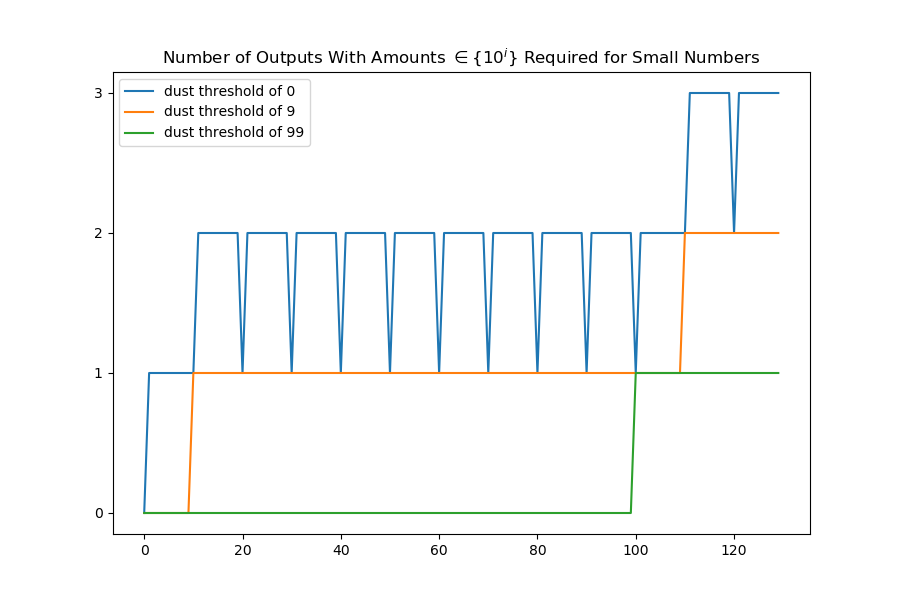

In [21]:
pd.DataFrame([ [ decimal_weight(i, dust_threshold=dust) for dust in (0, 9, 99) ] for i in range(0, 130) ], columns=['dust threshold of 0', 'dust threshold of 9',  'dust threshold of 99']).plot(yticks=range(0,4), title="Number of Outputs With Amounts $\in \{ 10^i \}$ Required for Small Numbers")

The following estimates the number of outputs needed when restricting the decimal representation to a [1-2-5 preferred value series](https://en.wikipedia.org/wiki/Preferred_number#1%E2%80%932%E2%80%935_series), which is commonly used for cash denominations:

In [22]:
def pvs_weight(amount : int, dust_threshold : int = 0, cost_per_output : int = 0) -> int:
    weight = 0
    remaining = amount
    
    p = 10 ** 16

    remaining -= cost_per_output

    while remaining > dust_threshold:
        while p > remaining:
            p = int(p / 10)
        
        if p == 0:
            return weight
        
        for m in (5,2,1):
            denom = m * p
            if denom < dust_threshold:
                return weight;
            if remaining >= denom:
                remaining -= denom + cost_per_output
                weight += 1
                break
                
    return weight

In [23]:
assert(1 == pvs_weight(1))
assert(1 == pvs_weight(2))
assert(1 == pvs_weight(10))
assert(2 == pvs_weight(12))
assert(3 == pvs_weight(13))
assert(3 == pvs_weight(14))
assert(2 == pvs_weight(15))
assert(1 == pvs_weight(13, dust_threshold = 4))
assert(1 == pvs_weight(13, cost_per_output = 3))
assert(2 == pvs_weight(13, cost_per_output = 1))
assert(1 == pvs_weight(13, cost_per_output = 1, dust_threshold=2))

<IPython.core.display.Javascript object>


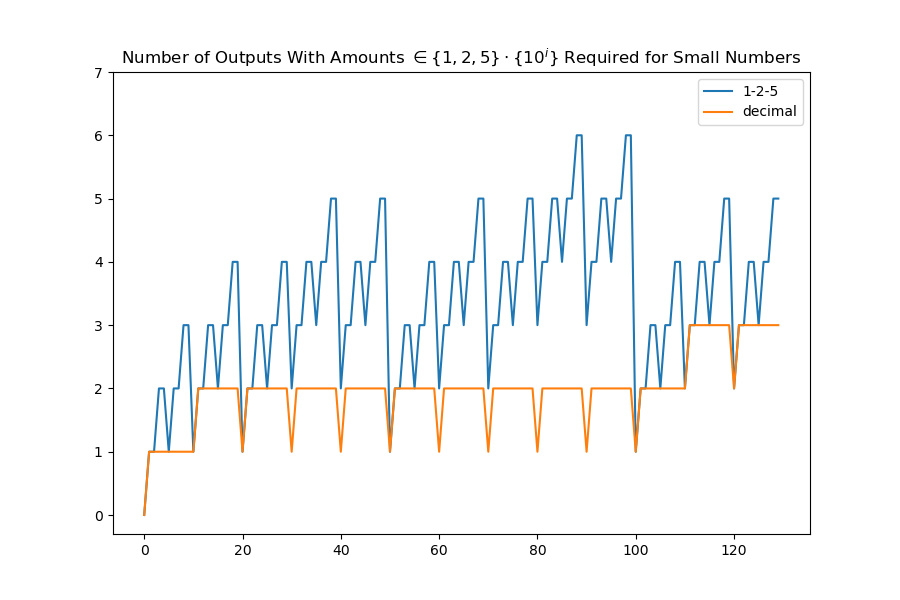

In [24]:
pd.DataFrame([ (pvs_weight(i), decimal_weight(i)) for i in range(0, 130) ], columns=['1-2-5','decimal']).plot(yticks=range(0,8), title="Number of Outputs With Amounts $\in \{ 1, 2, 5 \} \cdot \{ 10^i \}$ Required for Small Numbers")

Finally, this last kind of weight is not directly comparable with the other representations because
every digit in this base is some sum of powers of 2 and powers of 3, and most digits are 0. Because this weight is of a more theoretical interest as a benchmark, no dust and per output cost accounting has been done (and it's not clear how to me decompose this way from most to least significant digit).

In [25]:
def mixed_binary_ternary_weight(n : int):
    weight = 0;
    
    while n > 0:
        if n % 3 == 0:
            n = int(n / 3);
        elif n % 2 == 0:
            n = int(n / 2);
        else:
            weight += 1
            n -= 1
    
    return weight;

<IPython.core.display.Javascript object>


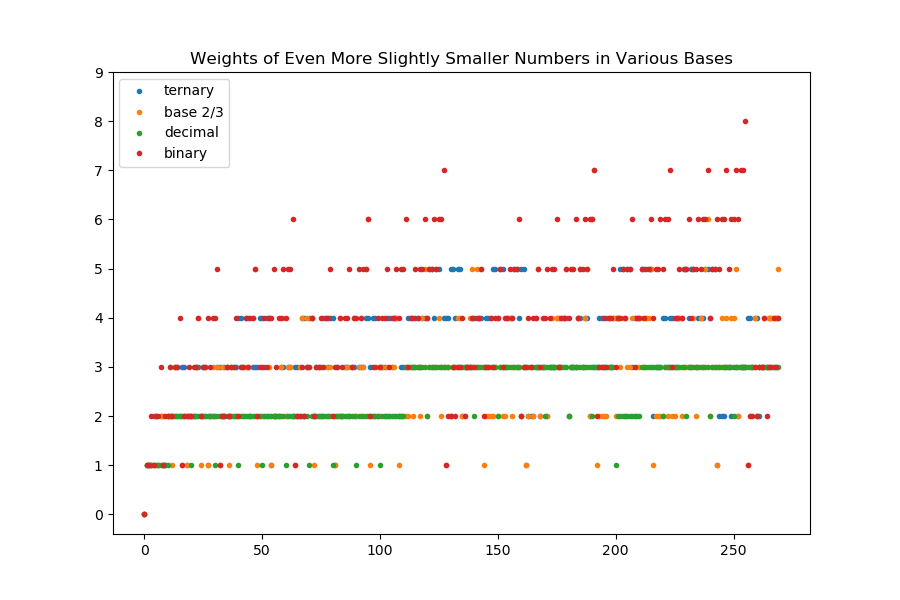

In [26]:
# TODO improve visibility of overlapping points

pd.DataFrame([ (ternary_weight(i), mixed_binary_ternary_weight(i), decimal_weight(i), popcount(i) ) for i in range(0, 270) ], columns=['ternary', 'base 2/3', 'decimal', 'binary']).plot(yticks=range(0,10), style='.', title="Weights of Even More Slightly Smaller Numbers in Various Bases")

We can now analyze the distributions of the weights for the Wasabi fresh input amounts:

In [27]:
wasabi_amounts['decimal'] = wasabi_amounts['sats'].map(decimal_weight)
wasabi_amounts['1-2-5'] = wasabi_amounts['sats'].map(pvs_weight)
wasabi_amounts['binary'] = wasabi_amounts['sats'].map(popcount)
wasabi_amounts['ternary'] = wasabi_amounts['sats'].map(ternary_weight)
wasabi_amounts['2/3'] = wasabi_amounts['sats'].map(mixed_binary_ternary_weight)

In [28]:
wasabi_amounts.sample(n=10)

,amount,sats,decimal,1-2-5,binary,ternary,2/3
19,0.100052,10005246,5,7,14,10,6
5545,0.017934,1793366,7,14,13,7,8
3053,0.100063,10006336,5,9,10,8,7
4770,0.052518,5251779,7,11,8,9,5
7579,0.323329,32332950,7,12,15,9,5
1102,0.800000,80000000,1,3,8,13,6
152,0.043929,4392932,7,14,10,11,11
454,0.042175,4217521,7,9,9,11,6
4164,0.029741,2974137,7,13,12,9,7
3936,0.097226,9722592,7,12,10,8,4


In [29]:
wasabi_amounts.describe()

,amount,sats,decimal,1-2-5,binary,ternary,2/3
count,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.359992,3.599917e+07,5.741000,10.744625,11.347625,9.858625,7.791750
std,2.060168,2.060168e+08,1.911054,4.190358,2.599544,2.028276,2.283754
min,0.000057,5.736000e+03,1.000000,1.000000,3.000000,4.000000,2.000000
25%,0.018764,1.876399e+06,5.000000,9.000000,10.000000,9.000000,6.000000
50%,0.055060,5.506016e+06,6.000000,11.000000,11.000000,10.000000,8.000000
75%,0.127704,1.277041e+07,7.000000,13.000000,13.000000,11.000000,9.000000
max,94.053521,9.405352e+09,10.000000,23.000000,21.000000,19.000000,19.000000


## Selecting Base Denominations

Here we specify some values which should be preferentially used for the amount decomposition algorithms we will use to simulate CoinJoin transactions using a 3 different bases: 2, 3, and 10 as hinted by the weight functions above.

Let's start with powers of these bases below the total number of satoshis that could ever exist:

In [30]:
powers_of_two   = [ 2**i  for i in range(0,50)]
powers_of_three = [ 3**i  for i in range(0,32)]
powers_of_ten   = [ 10**i for i in range(0,16)]

Next, we consider multiples of the powers.

In base 10 this would need 9 different digits for each decimal place, resulting in a large number of denominations, which can degrade privacy because it reduces the likelyhood of equal amount outputs. As previously mentioned, we'll use the familiar [1-2-5 series](https://en.wikipedia.org/wiki/Preferred_number#1%E2%80%932%E2%80%935_series) for decimal biased representation. Note that although it's not a place value numeration, this encoding is still bijective: instead of digits there are canonical multisets (e.g. the digit `9` is represented by `{ 5, 2, 2 }`, which is still a unique decomposition).

In [31]:
# some multiples may be too big, like 5e16
max_sats = 2099999997690000

def multiples(coefficients, values):
    return list(filter(lambda x: x < max_sats, [ c * v for c in coefficients for v in values ]))

ternary = multiples((1,2), powers_of_three)
preferred_value_series = multiples((1,2,5), powers_of_ten)

# odd multiples of powers of two might also be considered, but that's no longer a bijection
# see https://en.wikipedia.org/wiki/Preferred_number#Computer_engineering
binary_preferred_value_series = multiples((1,3,5), powers_of_two)

A downside of positional notation is that some numbers will have higher weights depending on the base, usually with abrupt jumps between adjacent values. Using several complementary bases we can allow for lighter decompositions.

The simple approach is just to choose the best base for each value, but this is still not necessarily optimal and can result in amounts with small differences but which fall on opposite sides of a large jump in the weight in some base would be more clearly related to the outputs, so can result in fragmentation of anonymity sets.

Allowing bases to be mixed we can find lighter or more private decompositions, but presents a non-linear combinatorial optimization problem that we will explore below.

In [32]:
# combine all the above and filter for duplicates
std_denoms = sorted(set(powers_of_two + ternary + preferred_value_series))

It's easiest to see the intuition for why combining these bases can result in more efficient decompositions by reviewing how addition works in binary. Notice that in base 2, when two values are added and a string of 1's in one number coincides in its least significant bit with a 1 in the other number, the resulting carry yields a single 1:

In [33]:
print(bin(31), '+', bin(1), '=', bin(31 + 1))
print(bin(28), '+', bin(4), '=', bin(28 + 4))

0b11111 + 0b1 = 0b100000
0b11100 + 0b100 = 0b100000


This means that a subtracting a value with a weight of 1 in some base may result in a remainder whose weight is lower by more than 1 in the other bases. When this is the case fewer outputs from the restricted set are required to decompose the given amount.

Looking at the binary representations of some of the values in this set we can see that these three bases are fairly complementary, contributing highly varied bit patterns.

In [34]:
pd.options.display.max_rows = None
pd.DataFrame(((str(denom/1e8), denom, bin(denom)[2:], popcount(denom), decimal_weight(denom), pvs_weight(denom), ternary_weight(denom)) for denom in filter(lambda x: 1e5 <= x and x <= 1e7, std_denoms)), columns=['amount', 'sats', 'bits', 'popcount', 'decimal weight', '1-2-5 weight', 'ternary weight'])

,amount,sats,bits,popcount,decimal weight,1-2-5 weight,ternary weight
0,0.001,100000,11000011010100000,6,1,1,7
1,0.00118098,118098,11100110101010010,9,5,11,1
2,0.00131072,131072,100000000000000000,1,5,7,9
3,0.00177147,177147,101011001111111011,13,6,10,1
4,0.002,200000,110000110101000000,6,1,1,7
5,0.00262144,262144,1000000000000000000,1,6,9,9
6,0.00354294,354294,1010110011111110110,13,6,11,1
7,0.005,500000,1111010000100100000,7,1,1,11
8,0.00524288,524288,10000000000000000000,1,6,11,9
9,0.00531441,531441,10000001101111110001,10,6,9,1


In the following plot we can see how the entire set distributes over the range of possible values. From a distance this looks like a pretty good approximation of a straight line in log scale, but zooming in we can see it's got some gaps.

<IPython.core.display.Javascript object>


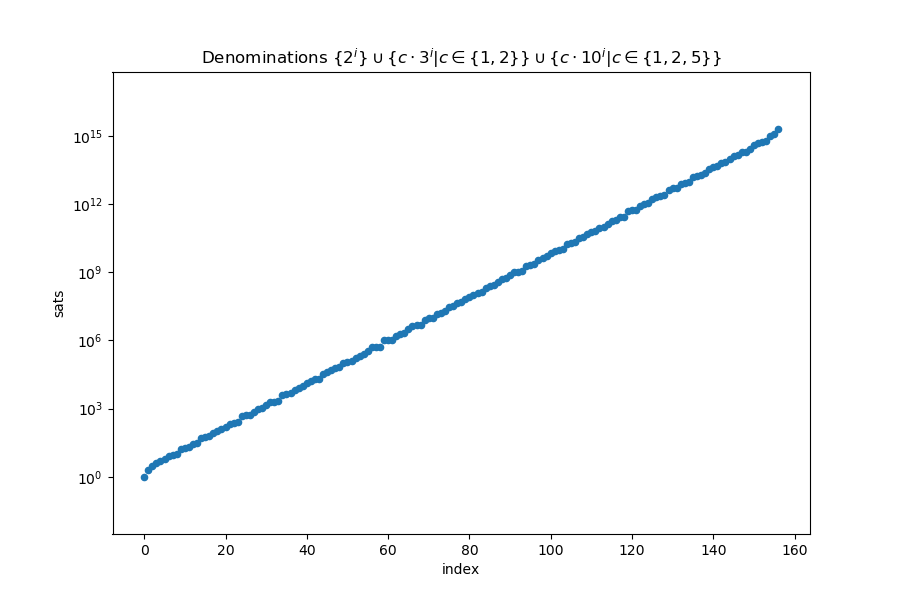

In [35]:
pd.DataFrame(std_denoms, columns=['sats']).reset_index().plot.scatter(x='index', y='sats', logy=True, title="Denominations $\{2^i\} \cup \{c \cdot 3^i | c \in \{1, 2\} \} \cup \{c \cdot 10^i | c \in \{1, 2, 5\} \}$")

We can also observe that there are roughly 10 denominations per order of magnitude. Unfortunately that's a large number of possibilities for transactions with a small number of users: too many denominations is detrimental for privacy because it fragments users and the presence of particular denominations can provide evidence for certain sub-transactions being more plausible than others.

Ideally we would like to see several inputs and outputs of all denominations across the range of values used in a transaction, sub-combinations of which are interchangeable with any arbitrary amount also appearingin the transaction. We will return to this problem later on, but to get some proportions, here are the values from each set in the range `[0.001,10.0) BTC` which as we shall see covers most of the amounts used as inputs in the current version of Wasabi.

In [36]:
def between(le, g):
    return lambda x: le <= x and x < g

print(len(list(filter(between(1e5, 1e9), std_denoms))), "possible denominations in the range [0.001,10.0) BTC\n")

for (n, s) in {"1-2-5": preferred_value_series, "binary": powers_of_two, "ternary": ternary}.items():
    filtered = list(map(lambda x: x/1e8, filter(between(1e5, 1e9),s)))
    print(len(filtered), n, "values:", *filtered, "\n")

42 possible denominations in the range [0.001,10.0) BTC

12 1-2-5 values: 0.001 0.01 0.1 1.0 0.002 0.02 0.2 2.0 0.005 0.05 0.5 5.0 

13 binary values: 0.00131072 0.00262144 0.00524288 0.01048576 0.02097152 0.04194304 0.08388608 0.16777216 0.33554432 0.67108864 1.34217728 2.68435456 5.36870912 

17 ternary values: 0.00177147 0.00531441 0.01594323 0.04782969 0.14348907 0.43046721 1.29140163 3.87420489 0.00118098 0.00354294 0.01062882 0.03188646 0.09565938 0.28697814 0.86093442 2.58280326 7.74840978 



With 42 possible values a large number of participants would be required to achieve privacy, especially if arbitrary amounts are also used and the variance is high. Reducing the density of the denomination set trades off block space for privacy, requiring more outputs overall and increasing the likelyhood that equal amounts will be used.

Note, however, that the privacy loss is partly mitigated because in some cases these values still relate to each other.

For example `0.01048576` (`2^20` sats) is a power of two that is `1424` sats under `0.01 + 0.0005`, so at a feerate of up to `14.3 sat/vbyte` (figuring `31 vbytes` per input and `68.5 vbytes` per output) two such 1-2-5 inputs could plausibly result in a the power of two output, and similarly the presence of say an input worth `4096` or `5000` sats might be merged with `0.01048576` in order to go the other direction.


In other words, it's an overly conservative assumption to consider only the equal amount outputs when estimating the lower bound on the number of non-derived sub-transactions, not just for heavier output amounts but also for standard denomination amounts (amounts in the restricted set are defined to have a Hamming weight of `1`).

For values above 1.0 BTC, as blockspace efficiency becomes less of a concern but the number of counterparties available for a mix does become more of a factor, so it makes sense to further constrain values and the 1-2-5 series seems like the logical choice for these larger values. However, we shall see below that this potentially introduces some issues as well.

In [37]:
std_denoms = list(filter(lambda x: x in preferred_value_series or x < 1e8, std_denoms))
large_pvs = list(filter(lambda x: 1e8 <= x, preferred_value_series))

<IPython.core.display.Javascript object>


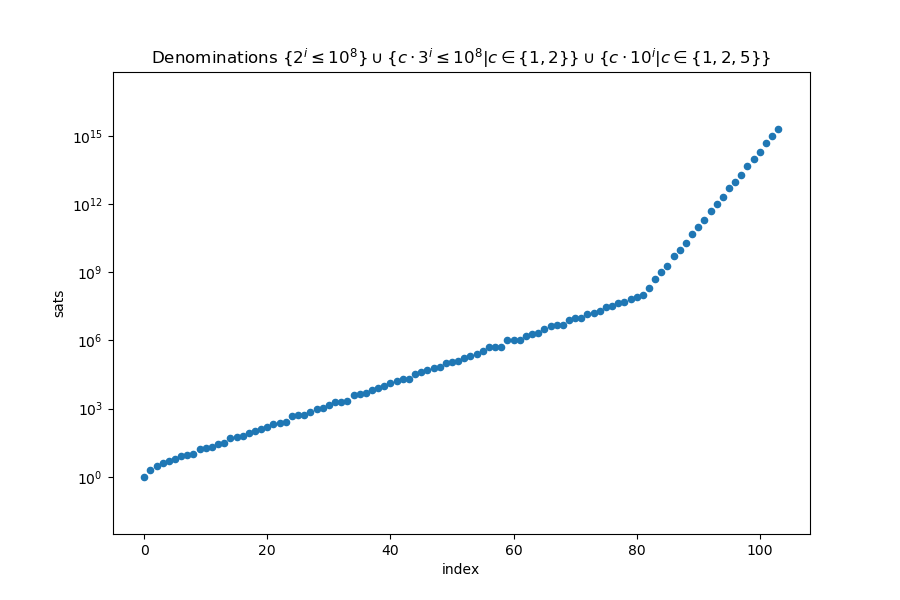

In [38]:
pd.DataFrame(std_denoms, columns=['sats']).reset_index().plot.scatter(x='index', y='sats', logy=True, title="Denominations $\{2^i \leq 10^8 \} \cup \{c \cdot 3^i \leq 10^8 | c \in \{1, 2\} \} \cup \{c \cdot 10^i | c \in \{1, 2, 5\}\}$")

Finally, [factorial](https://en.wikipedia.org/wiki/Factorial_number_system) and [primorial](https://oeis.org/wiki/Primorial_numeral_system) based number systems are interesting as a benchmark, as are the Fibonacci numbers since they are constructed by summation.

<IPython.core.display.Javascript object>


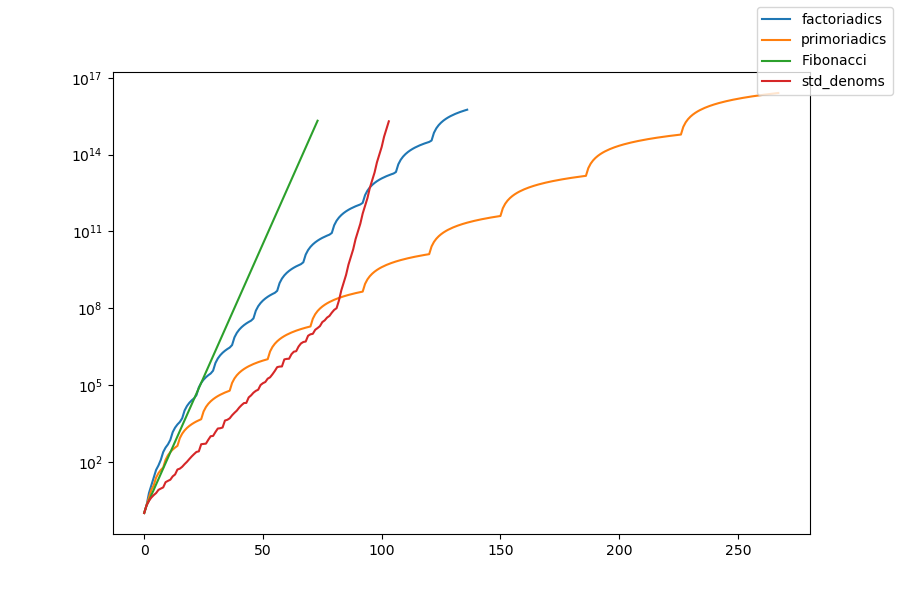

In [39]:
# TODO https://oeis.org/wiki/LCM_numeral_system ?

factorials = [1]
factoriadics = [1]
while factoriadics[-1] < max_sats:
    factorials.append(factorials[-1] * (1+len(factorials)))
    for i in range(1, len(factorials)):
        factoriadics.append(factorials[-1] * i)
        #print("digit", i, "of radix", len(factorials), "with place value", factorials[-1], "is", factoriadics[-1])

primes = [1, 2] # we need to know the next prime to know how many different digits are allowed
primorials = [1]
primoriadics = [1]
for new_prime in range(2, max_sats):
    for i in range(2,1+int(math.sqrt(new_prime))):
        if new_prime % i == 0:
            break
    else:
        last_prime = primes[-1]
        primes.append(new_prime)
        primorials.append(last_prime * primorials[-1])
        #print("new prime",new_prime, "last prime", last_prime, "primorial", primorials[-1])
        
        # digits are all the numbers until the next prime
        for i in range(1, new_prime):
            primoriadics.append(i * primorials[-1])
            #print("new primorial digit", primoriadics[-1])
        
    if primoriadics[-1] > max_sats:
        break

fibs = [1, 2] # skip the first [0,1] so we only have unique non-zero values
while fibs[-1] < max_sats:
    fibs.append(fibs[-1] + fibs[-2])

fig, ax = plt.subplots()
ax = pd.Series(factoriadics,name='factoriadics').plot(logy=True)
pd.Series(primoriadics, name='primoriadics').plot(logy=True, ax=ax)
pd.Series(fibs, name='Fibonacci').plot(logy=True, ax=ax)
pd.Series(std_denoms, name='std_denoms').plot(logy=True, ax=ax)
fig.legend()

## Decomposition Algorithms

In order to model a decomposition, we need to account for the values of the outputs as well as their blockspace requirement.

For our purposes a coin is an integer amount of satoshis that also knows its size in vbytes (currently hard coded to `p2wpkh` sizes). Other script types can be modeled by extending this type, but things such as discounts for standard denominations will probably need some refactoring, so consider it a work in progress.

In [40]:
class Coin(int):
    def __hash__(self):
        """
        coins have a unique identify even if their face value is the same.
        this is useful for constructing sets of coins.
        """
        return id(self)

    @property
    def output_vbytes(_):
        """
        the number of vbytes required to create this coin
        """
        return 31
    
    @property
    def input_vbytes(_):
        """
        the number of vbytes required to spend this coin (estimated)
        """
        return 68.5
    
    def effective_value(self, feerate) -> int:
        return self - int(feerate * self.input_vbytes) # FIXME round correctly, i think wasabi rounds towards zero
    
    def effective_cost(self, feerate) -> int:
        return self + int(feerate * self.output_vbytes) # FIXME round correctly, i think wasabi rounds towards zero

A decomposition is a bunch of coins. These should be thought of as an unordered set of coins, where duplicate amounts can occur but the same `Coin` object may only appear once.

In [41]:
from itertools import chain

class Decomposition(tuple): # also works as a subclass of frozenset, but that's significantly slower
    def extend(self, coin : Coin): # returns same type?
        """
        return a new decomposition with the additional coin included
        """
        return Decomposition(chain(self, (coin,)))

    @property
    def face_value(self) -> int:
        """
        returns the sum of the coin's nominal amounts
        """
        return sum(self)

    @property
    def outputs_vbytes(self) -> int:
        """
        returns the sum of the vbytes required to create the coins
        """
        return sum(coin.output_vbytes for coin in self)

    @property
    def inputs_vbytes(self) -> int:
        """
        returns the sum of the vbytes required to spend the coins
        """
        return sum(coin.input_vbytes for coin in self)

    def effective_value(self, feerate) -> int:
        return self.face_value - int(feerate * 68.5 * len(self))

    def effective_cost(self, feerate) -> int:
        return self.face_value - int(feerate * 31 * len(self))

And with these data types we can define an interface for returning decompositions given some balance amount:

In [42]:
from typing_extensions import Protocol

class AmountDecomposer(Protocol):
    def decompose(self, amount : int, dust_threshold : int = 0, feerate : int = 0) -> Decomposition:
        pass

### Decomposition Using an Arbitrary Set of Values

Next, we want to concretely derive decompositions, i.e. lists of values to use as output amounts given some remaining balance by choosing output values from an arbitrary restricted set.

The following base class is shared by the different strategies, which differ in how successive values used in the decomposition are chosen from the set.

The dust threshold further restricts the set. When the remaining amount (minus the cost of an output) smaller than all of the allowed values in the set but is still above the dust threshold itself, a change output will be created.

In [43]:
from typing import Optional, Iterable, Tuple
from itertools import chain
from bisect import bisect_right
import attr

@attr.s(auto_attribs=True, kw_only=True, slots=True)
class RestrictedSetDecomposer(object):
    def _normalize_value_set(values: Iterable[int]) -> Tuple[int]:
        return tuple(sorted(set(chain([0], values))))

    # we keep the values as an ordered list
    values : Tuple[int] = attr.ib(converter=_normalize_value_set)

    # perhaps this abstract method interface may need to be revised to be given a list of the amounts so far
    def pick_next_amount(self, remaining : int, dust_threshold : int) -> Optional[int]:
        pass

    def decompose(self, amount : int, dust_threshold : int = 0, feerate : int = 0, initial : Decomposition = Decomposition()) -> Decomposition:
        """
        dust_threshold controls when the decomposition ends.

        feerate * size is subtracted from the remaining amount for each new amount created.
        """
        solution = initial
        remaining = amount - feerate * Coin(amount).output_vbytes

        while remaining > dust_threshold:
            denom = self.pick_next_amount(remaining, dust_threshold)
            if denom is None:
                break;
            coin = Coin(denom)
            solution = solution.extend(coin)
            remaining -= coin.effective_cost(feerate)

        if remaining > dust_threshold:
            # add a change amount
            # TODO rounding? fuzzing?
            solution = solution.extend(Coin(remaining))
            
            # FIXME how to account for higher hamming weight?

            # add the minimum hamming weight between the different bases above the dust threshold for the change amount
            # FIXME this is kind of broken since it makes assumptions about the values and really belongs elsewhere
            #weight += min(popcount(remaining, dust_threshold), decimal_weight(remaining, dust_threshold), ternary_weight(remaining, dust_threshold))

        return solution

    # helper methods for interrogating the set of allowed denoms
    def largest_denom_below_incl(self, amount : int) -> Optional[int]:
        # within is meant to imply smaller than or equal without being so long
        # bisect_right will always return the index of the next element greater than amount, so offset by -1
        return self.index_to_denom(self.bisect_denoms(amount, offset=(-1)))

    def smallest_denom_above(self, amount : int) -> Optional[int]:
        return self.index_to_denom(self.bisect_denoms(amount))

    def index_to_denom(self, i : int) -> Optional[int]:
        # filter out dummy 0 value and out of bounds indices
        if i <= 0 or i >= len(self.values):
            return None;

        return self.values[i]

    # FIXME
    # this method kind of violate encapsulation since they leak internal indices of the values list.
    # for now it's fine since the denom set is totally ordered by amount, but maybe it needs to be
    # cleaned up so that it can be shared by stochastic/greedy subclasses in a different way
    def bisect_denoms(self, amount : int, offset : int = 0) -> int:
        assert(amount >= 0)
        return offset + bisect_right(self.values, amount)

In [44]:
# some basic tests to ensure bisection works correctly

d1 = RestrictedSetDecomposer(values=[1,2])

assert(1 == d1.largest_denom_below_incl(1))
assert(2 == d1.largest_denom_below_incl(2))
assert(2 == d1.largest_denom_below_incl(3))
assert(2 == d1.largest_denom_below_incl(4))
assert(1 == d1.smallest_denom_above(0))
assert(2 == d1.smallest_denom_above(1))
assert(d1.smallest_denom_above(2) is None)

d2 = RestrictedSetDecomposer(values=[2,4])

assert(d2.largest_denom_below_incl(1) is None)
assert(2 == d2.largest_denom_below_incl(2))
assert(2 == d2.largest_denom_below_incl(3))
assert(4 == d2.largest_denom_below_incl(4))
assert(4 == d2.largest_denom_below_incl(5))
assert(2 == d2.smallest_denom_above(0))
assert(2 == d2.smallest_denom_above(1))
assert(4 == d2.smallest_denom_above(3))
assert(d2.smallest_denom_above(4) is None)

### Greedy (deterministic, mixed std denoms)

The greedy strategy always picks the next largest amount from the specified denomination set.

In [45]:
class Greedy(RestrictedSetDecomposer):
    def pick_next_amount(self, remaining : int, dust_threshold : int) -> Optional[int]:
        return self.largest_denom_below_incl(remaining)

### Stochastic

This strategy decomposes an amount probablistically, by choosing the next amount randomly. The stronger the bias towards larger amounts, the more this approaches the behaviour of the greedy algorithm.

Note that this is a one-shot algorithm, and iterative optimization of solutions happens in subclasses (see `BestOfN` and `SimulatedAnnealing` subclasses below).

In [46]:
# TODO separate these into separate functions, since the simulated
# annealing also needs to consider biases and exponential was not rigorously checked even just for BestOfN
def default_bias(amount : int) -> float:
    """
    returns a weight for a given amount
    """
    # these values are illegal and can never occur
    # an amount of 0 can appear on the blockchain, but serves no purpose in amount decomposition
    if amount <= 0 or amount >= max_sats:
        return 0;

    # normalize to a fraction in the range the range (0,max_sats)
    x = (amount+0.0)/max_sats

    return math.expm1(x)
    #return x**2
    #return x
    #return math.sqrt(x)
    #return log(x)
    #return 1 # uniform

In [47]:
from typing import Callable, List, Optional
import bisect
import math
import random
from itertools import accumulate

@attr.s(auto_attribs=True, slots=True)
class Stochastic(RestrictedSetDecomposer):
    bias : Callable[[int], float] = default_bias
    cum_weights : Tuple[int] = attr.ib()
    
    @cum_weights.default
    def _calculate_cum_weights(self):
        """
        pre-compute cumulative weights for the values in the set
        """
        return tuple(accumulate(map(self.bias, self.values)))

    def pick_random_denomination(self, above : int, below_incl : int) -> Optional[int]:
        """
        pick a random value from the set between `above` and `below_incl` 
        """
        # find the indices of denominations specified by smallest and largest
        i = self.bisect_denoms(above)
        j = self.bisect_denoms(below_incl, offset=-1) + 1

        if j <= i:
            # no values in the range
            return None

        # generate a random value in the weighted range, find the index in
        # the cumulative distribution and return the corresponding base denom
        if i == 1:
            # when i is 1 (recall that there is an extra 0 in the list to avoid bounds checking)
            # we can use the standard library function, which is faster
            return random.choices(self.values[i:j], cum_weights=self.cum_weights[i:j], k=1)[0]
        else:
            # when we only want to sample a subrange the cumulative weights can be
            # used as affine values but random.choices doesn't support this directly
            # this is still much faster than random.choices with just weights since it
            # avoids recalculating the cumulative weights
            r = random.uniform(self.cum_weights[i-1], self.cum_weights[j-1])
            return self.index_to_denom(bisect.bisect_right(self.cum_weights, r, i, j))

    def pick_next_amount(self, remaining : int, dust_threshold : int) -> Optional[int]:
        return self.pick_random_denomination(dust_threshold, remaining)

## Optimization

#### Cost Functions

In order to optimize over the space of solutions we must be able to compare them using a cost function.

In [48]:
import math
from typing_extensions import Protocol

class CostFunction(Protocol):
    def cost(self, solution : Decomposition) -> float:
        pass

We will revisit this, but for now the following cost function will suffice:

In [49]:
@attr.s(auto_attribs=True, slots=True)
class BasicCostFunction(object):
    amount : int
    dust_threshold : int
    feerate : int
        
    @property
    def capped_amount(self) -> int:
        return self.amount - self.dust_threshold

    def cost(self, s : Decomposition) -> float:
        """
        penalize a solution for its implied input fees and reward it for claimed amount, up to the dust threshold.
        the score is normalized in relation to the amount.
        """
        
        # TODO self.feerate is actually not appropriate here since what actually matters
        # is the expectation of future fees
        return (self.feerate * s.inputs_vbytes - min(s.face_value, self.capped_amount))/amount

In [50]:
default_cost_function_factory : Callable[...,CostFunction] = BasicCostFunction

#### Best of N

This simple optimizer just runs the stochastic strategy `n` times, randomly sampling the search space, and returns the solution with the minimum value according to an arbitrary cost function.

In [51]:
from typing import Iterator, Callable

@attr.s(auto_attribs=True, slots=True)
class BestOfN(Stochastic):
    """
    choose minimum value given a cost function from multiple attempts 
    """
    n : int = 1000
    cost_function_factory : Callable[...,CostFunction] = default_cost_function_factory

    def decompose(self, amount : int, dust_threshold : int = 0, feerate : int = 0, initial : Decomposition = Decomposition()) -> Decomposition:
        cost_function = self.cost_function_factory(amount=amount, dust_threshold=dust_threshold, feerate=feerate).cost
        return min(self.decompositions(amount, dust_threshold, feerate, initial), key=cost_function)
    
    def decompositions(self, amount : int, dust_threshold : int, feerate : int, initial : Decomposition) -> Iterator[Decomposition]:
        """
        """
        for _ in range(0, self.n):
            yield super().decompose(amount, dust_threshold, feerate, initial)


#### Simulated Annealing

This decomposer extends search space with a notion of locality. For a given solution, "nearby" solutions are generated by removing or adding outputs randomly. A more sophisticated approach might be to use some kind of genetic algorithm, but this seems to work well enough for now, and can be always be improved at a later point.

The search proceeds much like a greedy "hill climbing" algorithm (well, valleys, given we're using a cost/loss function), so when a neighbouring solution is better than the current solution, it replaces the current solution. However, to avoid getting stuck in local minima, when a worse solution is generated it may still be accepted depending "temperature" value which decreases with time.

In order to evaluate neighboring solutions more easily, instead of computing the cost function on the partial solutions they are first completed with the greedy strategy.

In [52]:
# TODO
# - lots of magic numbers left over
# - clean up the neighbor() function

from typing import Tuple

@attr.s(auto_attribs=True, slots=True)
class SimulatedAnnealing(Stochastic):
    n : int = 1000
    starting_temperature : float = 1.0
    cost_function_factory : Callable[...,CostFunction] = default_cost_function_factory

    # FIXME
    # this method needs clean up
    # basically it should efficiently and fairly drop or extend solutions when either is possible
    # however, to know whether or not we can extend a solution we need to try and pick the next denomination first
    # how can this be done both fairly and efficiently?
    def neighbor(self, d : Decomposition, remaining : int, dust_threshold : int, feerate : int) -> Tuple[Decomposition, int]:
        """
        given a solution, return a neighbouring solution
        """
        denom = None
        
        # first try dropping some output values from the solution
        # the larger the solution the more likely we are to drop values from it
        # if this is done only once then eventually things converge on large
        # solutions made up of very small output amounts
        cost_per_output = feerate * Coin(amount).output_vbytes

        for drop_prob in (0.5, 1.0):
            if len(d) > 0 and random.random() < drop_prob * (1+math.log(len(d))):
                as_list : List[Coin] = list(d)
                picked = random.choices(range(0, len(as_list)), weights=[ (max_sats - x)/max_sats for x in as_list ])[0] # FIXME extract additional other bias function?
                removed = as_list.pop(picked)
                return (Decomposition(as_list), remaining + removed.effective_cost(feerate))
            # pick a value to extend the solution with
            # pick_next_amount uses the same bias as the stochastic algorithm
            # which at the time of writing this comment is a little too aggressive
            # being exponential, so instead we just pick uniformly at random half the time
            # this needs to be refactored so that multiple bias functions are just available
            # and each stochastic decomposer (or subclass) is given the appropriate one based
            # on the algorithm and the parameters
            elif remaining - cost_per_output > 0:
                # FIXME the default_bias function above is not so good, find a better one and remove this branch
                if random.random() < 0.25:
                    i = 1 if dust_threshold == 0 else self.bisect_denoms(dust_threshold)
                    j = self.bisect_denoms(remaining - cost_per_output, offset=-1) + 1
                    if i < j:
                        if drop_prob >= 1:
                            print("wtf")
                        denom = random.choice(self.values[i:j])
                else:
                    denom = self.pick_next_amount(remaining - cost_per_output, dust_threshold)

                if denom is not None:
                    coin = Coin(denom)
                    #print("extending", denom, "remaining", remaining)
                    d = d.extend(coin)
                    remaining -= coin.effective_cost(feerate)
                    break

        return (d, remaining)

    def decompose(self, amount : int, dust_threshold : int = 0, feerate : int = 0, initial : Decomposition = Decomposition()) -> Decomposition:
        """
        find a solution to decomposing `amount` by simulated annealing.
        """
        # to evaluate the cost of partial solutions, wrap the supplied cost function.
        # partial solutions are completed using the greedy strategy, and the costs of
        # both the partial solution and the completed one are taken into account.
        # this effectively scores the remaining amount of a partial solution.
        cost_function = self.cost_function_factory(amount=amount, dust_threshold=dust_threshold, feerate=feerate).cost
        def compute_cost(decomposition : Decomposition) -> Tuple[float, int]:
            completed = Greedy.decompose(self, remaining, dust_threshold, feerate, decomposition)
            return (cost_function(decomposition) + cost_function(completed), len(completed))
            # (FIXME why does the above work better?)
            #return (cost_function(completed), len(completed))

        solution = initial
        remaining = amount
        (cost, total_length) = compute_cost(solution)

        # we also want to track the best solution, since metaparameter values aren't yet settled
        best_solution = solution
        best_cost = cost
        best_remaining = remaining

        # simulate annealing
        # temperature is arbitrary and must be tuned for the cost function
        # small temperatures such as 0.001 work nicely when the cost function is normalized based on the cost of the solution divided by the input amount
        # the number of steps controls the step size
        for i in range(self.n, 1, -1):
            temperature = self.starting_temperature * i/self.n
            
            # given the current solution, find a neighbouring solution
            (new_solution, new_remaining) = self.neighbor(solution, remaining, dust_threshold, feerate)
            (new_cost, new_total_length) = compute_cost(new_solution)
            
            # the following is helpful when tuning temp/iterations/cost function
            #if (i % int(self.n / 13) == 0 or min(i, self.n+1-i) < 10):
            #    print(i, (new_cost - cost), "prob", math.exp(- (new_cost - cost) / temperature), "remaining", remaining, new_remaining, "costs", cost, new_cost, "lengths", len(solution), len(new_solution), "total lengths", total_length, new_total_length)#, solution)
            
            # if the new solution is better, accept it as the new solution.
            # if the new solution is not better, accept it with a probability
            # depending on the difference in cost and the current temperature
            # smaller differences and higher temperatures both result in a higher
            # probability of accepting a worse solution, and the probability
            # diminishes as temperature decreases.
            if new_cost < cost or random.random() < math.exp((cost-new_cost)/ temperature):
                solution = new_solution
                cost = new_cost
                remaining = new_remaining
                total_length = new_total_length

            # also track the best solution we saw overall
            if new_cost < best_cost:
                best_solution = new_solution
                best_cost = new_cost
                best_remaining = new_remaining

        # if the annealing didn't end up at the best solution
        # switch back to it. if this happens too often then the
        # parameters are badly tuned, for example starting temp is too high
        if best_cost < cost:
            #if best_remaining - cost_per_output > dust_threshold:
            #    print("derp")
            solution = best_solution
            remaining = best_remaining

        # decompose the remaining amount greedily, since that's what we've been evaluating.
        if remaining - feerate * Coin(remaining).output_vbytes > dust_threshold:
            solution = Greedy.decompose(self, remaining, dust_threshold, feerate, solution)

        return solution

Let's decompose a few random hypothetical input clusters drawn from this distribution:

In [53]:
iters = 5000

all_denoms = preferred_value_series + powers_of_two + powers_of_three + fibs + factoriadics + primoriadics

strategies = {
    "greedy 1-2-5 * 10^i": Greedy(values=preferred_value_series),
    "greedy binary": Greedy(values=powers_of_two),
    "greedy binary 1-3-5 * 2^i": Greedy(values=binary_preferred_value_series),
    "greedy ternary": Greedy(values=ternary),
    "greedy binary + ternary": Greedy(values=powers_of_two + ternary),
    "greedy binary + ternary + 1-2-5": Greedy(values=std_denoms),
    "stochastic binary + ternary + 1-2-5": BestOfN(n=iters, values=std_denoms),
    "annealing binary + ternary + 1-2-5": SimulatedAnnealing(n=iters, values=std_denoms, starting_temperature=1.0),
    "stochastic 1-3-5 * 2^i": BestOfN(n=iters, values=binary_preferred_value_series),
    "annealing 1-3-5 * 2^i": SimulatedAnnealing(n=iters, values=binary_preferred_value_series, starting_temperature=1.0),
    "greedy fibs": Greedy(values=fibs),
    "stochastic fibs": BestOfN(n=iters, values=fibs),
    "annealing fibs": SimulatedAnnealing(n=iters, values=fibs, starting_temperature=1.0),
    "greedy factoriadics": Greedy(values=factoriadics),
    "stochastic factoriadics": BestOfN(n=iters, values=factoriadics),
    "annealing factoriadics": SimulatedAnnealing(n=iters, values=factoriadics, starting_temperature=1.0),
    "greedy primoriadics": Greedy(values=primoriadics),
    "stochastic primoriadics": BestOfN(n=iters, values=primoriadics),
    "annealing primoriadics": SimulatedAnnealing(n=iters, values=primoriadics, starting_temperature=1.0),
    "greedy everything": Greedy(values=all_denoms),
    "stochastic everything": BestOfN(n=iters, values=all_denoms),
    "annealing everything": SimulatedAnnealing(n=iters, values=all_denoms, starting_temperature=1.0),
}

feerate = 20
dust_threshold=4999

for i in range(0,5):
    cluster_size = random.randint(1,3)
    cluster = random.choices(wasabi_amounts['sats'], k=cluster_size)
    amount = int(sum(cluster))

    print("Total input amount", amount/1e8, "from", len(cluster), "input(s)", cluster, "\n")

    for (name, strategy) in strategies.items():
        for _ in range(0, 1 if not isinstance(strategy, Stochastic) else 3):
            solution = strategy.decompose(amount, feerate=feerate, dust_threshold=dust_threshold)
            print("  ", name, sum(solution) - amount, "sats,", "fees:", len(solution), "outs =", feerate*solution.outputs_vbytes, sorted(solution, reverse=True))
    print("\n")

Total input amount 1.55514839 from 1 input(s) [155514839] 

   greedy 1-2-5 * 10^i -4839 sats, fees: 5 outs = 3100 [100000000, 50000000, 5000000, 500000, 10000]
   greedy binary -6103 sats, fees: 7 outs = 4340 [134217728, 16777216, 4194304, 262144, 32768, 16384, 8192]
   greedy binary 1-3-5 * 2^i -4055 sats, fees: 5 outs = 3100 [134217728, 20971520, 262144, 49152, 10240]
   greedy ternary -6017 sats, fees: 9 outs = 5580 [129140163, 14348907, 9565938, 1594323, 531441, 177147, 118098, 19683, 13122]
   greedy binary + ternary -4398 sats, fees: 5 outs = 3100 [134217728, 16777216, 4194304, 262144, 59049]
   greedy binary + ternary + 1-2-5 -4839 sats, fees: 5 outs = 3100 [100000000, 50000000, 5000000, 500000, 10000]
   stochastic binary + ternary + 1-2-5 -4839 sats, fees: 5 outs = 3100 [100000000, 50000000, 5000000, 500000, 10000]
   stochastic binary + ternary + 1-2-5 -4839 sats, fees: 5 outs = 3100 [100000000, 50000000, 5000000, 500000, 10000]
   stochastic binary + ternary + 1-2-5 -4839 s

   annealing factoriadics -4815 sats, fees: 5 outs = 3100 [21772800, 282240, 120960, 30240, 5040]
   greedy primoriadics -3135 sats, fees: 4 outs = 2480 [19399380, 2042040, 720720, 50820]
   stochastic primoriadics -3135 sats, fees: 4 outs = 2480 [17357340, 4084080, 720720, 50820]
   stochastic primoriadics -3135 sats, fees: 4 outs = 2480 [17357340, 4084080, 720720, 50820]
   stochastic primoriadics -3135 sats, fees: 4 outs = 2480 [15315300, 6126120, 720720, 50820]
   annealing primoriadics -3135 sats, fees: 4 outs = 2480 [19399380, 2042040, 720720, 50820]
   annealing primoriadics -7755 sats, fees: 6 outs = 3720 [13273260, 8168160, 720720, 27720, 9240, 9240]
   annealing primoriadics -3135 sats, fees: 4 outs = 2480 [19399380, 2042040, 720720, 50820]
   greedy everything -2715 sats, fees: 3 outs = 1860 [21772800, 420420, 20160]
   stochastic everything -4524 sats, fees: 3 outs = 1860 [21772800, 317811, 120960]
   stochastic everything -2334 sats, fees: 3 outs = 1860 [14930352, 5105100,

   stochastic factoriadics -2486 sats, fees: 4 outs = 2480 [32659200, 1451520, 241920, 5040]
   annealing factoriadics -2486 sats, fees: 4 outs = 2480 [32659200, 1451520, 241920, 5040]
   annealing factoriadics -2486 sats, fees: 4 outs = 2480 [32659200, 1451520, 241920, 5040]
   annealing factoriadics -2486 sats, fees: 4 outs = 2480 [32659200, 1451520, 241920, 5040]
   greedy primoriadics -5846 sats, fees: 3 outs = 1860 [19399380, 14294280, 660660]
   stochastic primoriadics -5846 sats, fees: 3 outs = 1860 [19399380, 14294280, 660660]
   stochastic primoriadics -5846 sats, fees: 3 outs = 1860 [18378360, 15315300, 660660]
   stochastic primoriadics -5846 sats, fees: 3 outs = 1860 [19399380, 14294280, 660660]
   annealing primoriadics -5846 sats, fees: 3 outs = 1860 [18378360, 15315300, 660660]
   annealing primoriadics -5846 sats, fees: 3 outs = 1860 [18378360, 15315300, 660660]
   annealing primoriadics -5846 sats, fees: 3 outs = 1860 [18378360, 15315300, 660660]
   greedy everything -

TODO

- plot simulated annealing iterations
  - a bit hacky, but can do done instrumenting cost function without modifying the optimizer
- systematically compare different strategies
  - plot cost function distributions as function of
    - iterations
    - cost function (esp. in relation to temperature for annealing)
    - bias function
    - denomination sets

## Interactive Plot of Decomposition Weights of Various Amounts

This section lets you explore some of the parameters of decomposition for sequences or random samples of amounts, using the different strategies.

See below for explanation of the next plot and how to manipulate it, the following is just the nasty bits to put it together, made interactive with `ipywidgets` in the next notebook cell.

In [54]:
# needs a lot of refactoring
# - split into two functions (at least):
#   - plot given solutions with interactive parameters
#   - wrapper with more interactive parameters to generate solutions over some domain
# - be able to specify cost function
#   - per user cost function
# - remove random.seed hack, find a reasonable way to ensure provide replicability

import math
import matplotlib.pyplot as plt

def plot_amount_decompositions(amounts : list,
                               dust_threshold : int = 0,
                               sat_per_vbyte : int = 0,
                               iters_stochastic : int = 1,
                               iters_annealing : int = 1,
                               starting_temperature : float = 0.01,
                               drop_fraction : float = 0.0,
                               drop_from_homogenous = False,
                               show_stochastic = False,
                               show_min = False,
                               available_denoms = None):
    
    cost_per_output = 31 * sat_per_vbyte # assues p2wpkh FIXME refactor everything to just use feerate
    
    # functions for computing weights
    # when dropping from homogenous values, these are replaced with greedy decomposition
    binary = lambda x: popcount(x, dust_threshold, cost_per_output)
    pvs = lambda x: pvs_weight(x, dust_threshold, cost_per_output)
    ternary = lambda x: ternary_weight(x, dust_threshold, cost_per_output)
    
    # drop some fraction of denoms randomly
    # this works very badly, the main value is to demonstrate how badly
    if available_denoms is None:
        if drop_fraction > 0:
            available_denoms = list(filter(lambda _: random.random() > drop_fraction, std_denoms))
        else:
            available_denoms = std_denoms

    if drop_from_homogenous:
        # TODO refactor into some helper function?
        greedy_binary = Greedy(values=filter(lambda x: x in available_denoms, powers_of_two))
        binary = lambda x: len(greedy_binary.decompose(x, dust_threshold, cost_per_output))
        greedy_pvs = Greedy(values=filter(lambda x: x in available_denoms, preferred_value_series))
        pvs = lambda x: len(greedy_pvs.decompose(x, dust_threshold, cost_per_output))
        greedy_ternary = Greedy(values=filter(lambda x: x in available_denoms, powers_of_three))
        ternary = lambda x: len(greedy_ternary.decompose(x, dust_threshold, cost_per_output))

    greedy = Greedy(values=available_denoms)
    stochastic = BestOfN(n=iters_stochastic, values=available_denoms)
    annealing = SimulatedAnnealing(n=iters_annealing, starting_temperature=starting_temperature, values=available_denoms)

    # decompose amounts deterministically and stochastically
    # TODO account for loss and per output costs in sorting? sort by c * weight * cost_per_output + slippage? 
    # TODO limit depth for stochastic decomposition (when exceeds min seen depth? hard limit?) 
    greedy_decompositions = [ greedy.decompose(x, dust_threshold, cost_per_output) for x in amounts ]
    if show_stochastic:
        stochastic_decompositions = [ stochastic.decompose(x, dust_threshold, cost_per_output) for x in amounts ]
        annealing_decompositions = [ annealing.decompose(x, dust_threshold, cost_per_output) for x in amounts ]
    else:
        stochastic_decompositions = []
        annealing_decompositions = []
    
    # TODO plot best decomposition in a second figure?
    
    # extract just the weights of the decompositions
    g = [ len(x) for x in greedy_decompositions ]
    s = [ len(x) for x in stochastic_decompositions ]
    a = [ len(x) for x in annealing_decompositions ]
    
    # various dependent variables
    b = list(map(binary, amounts))
    d = list(map(pvs, amounts))
    t = list(map(ternary, amounts))
    
    # compute floor of all values except best stochastic weight
    f = list(map(lambda i: min(b[i], d[i], t[i], g[i]), range(0, len(amounts))))
    # also for stochastic
    if show_stochastic:
        fs = list(map(lambda i: min(b[i], d[i], t[i], g[i], s[i],a[i]), range(0, len(amounts))))
    else:
        fs = []
        
    # mixed binary/ternary - a whole class of bases from powers of 2 and powers of 3
    #m = list(map(lambda x: mixed_binary_ternary_weight(x), amounts))

    fig = plt.figure(figsize=(9, 6)) # TODO move to args
    
    # keep y axis stable when varying parameters or viewing different x value ranges
    # since hamming weights are logarithmic in the values this only grows large with drop_fraction
    plt.ylim([0.5,30.5])
    
    if show_min:
        if show_stochastic:
            plt.plot(amounts, fs, 'y-', label="min (w/ stochastic)")
        plt.plot(amounts, f, 'c-', label="min") # floor line
    
    # mixed 2/3 base, this not considered for floor line since it's not really comparable to the others
    # plt.plot(amounts, m, 'yx',)
    
    # plot (as points) hamming weights in different bases (greedy decomposition in fixed base)
    plt.plot(amounts, t, 'b.', label="ternary")
    plt.plot(amounts, d, 'g.', label="1-2-5")
    plt.plot(amounts, b, 'r.', label="binary")
    
    # plot  hamming weights from the mixed base decomposition algorithms, and the minimum value of all weights
    plt.plot(amounts, g, 'k.', label="greedy")
    if show_stochastic:
        plt.plot(amounts, a, 'mx', label="annealing")
        plt.plot(amounts, s, 'y.', label="stochastic")
    
    plt.xscale('log')
    
    plt.title("Number of Outputs Required Using Various Strategies")
    
    fig.legend()
    # TODO improve axis labels (bitcoin amounts on x axis), legend, etc
    # TODO also show the exp values for step size, start point, dust threshold

    plt.show()
    
    return (greedy_decompositions, stochastic_decompositions, annealing_decompositions)

In [55]:
from ipywidgets import interactive, widgets


def plot_decompositions(points : int = 500,
                        values = 'sequence',
                        random_seed = 1,
                        start : float = 1e7-50, # just below 1e7 to show weight transitions clearly
                        step : float = 1,
                        dust_threshold : int = 0,
                        sat_per_vbyte : int = 0,
                        iters_stochastic : float = 1,
                        iters_annealing : float = 1,
                        starting_temperature : float = 0.01,
                        drop_fraction : float = 0.0,
                        drop_from_homogenous = False,
                        show_stochastic = False,
                        show_min = False):

    random.seed(random_seed)
    
    if values == 'sequence':
        amounts = list(range(int(start), int(start+points*step), int(step)))
    else:
        amounts = sorted(random.sample(list(wasabi_amounts['sats']), k=points))
    
    return plot_amount_decompositions(amounts, int(dust_threshold), sat_per_vbyte, int(iters_stochastic), int(iters_annealing), starting_temperature, drop_fraction, drop_from_homogenous, show_stochastic, show_min)

plot = interactive(plot_decompositions,
                   values = ['sample', 'sequence'],
                   random_seed = (0,200),
                   points = widgets.IntSlider(value=100, min=1,max=1000, continuous_update=False), # slows down graph redraw linearly22
                   start = widgets.FloatLogSlider(value = 1e7-50, base=10, min=0, max=9, continuous_update=False), # slows down graph redraw logarithmically
                   step = widgets.FloatLogSlider(value=1, base=10, min=0, max=7, continuous_update=False), # same as start
                   dust_threshold=widgets.FloatLogSlider(base=10, value=0, min=-0.001, max=5, continuous_update=False),
                   iters_stochastic = widgets.FloatLogSlider(value=1, base=10, min=0, max=4, continuous_update=False), # slows down graph redraw exponentially
                   iters_annealing = widgets.FloatLogSlider(value=1, base=10, min=0, max=4, continuous_update=False), # slows down graph redraw exponentially
                   starting_temperature = widgets.FloatLogSlider(value=1.0, base=10, min=-4, max=2, continuous_update=False), # slows down graph redraw exponentially
                   sat_per_vbyte = widgets.IntSlider(value=1, min=0, max=1000, continuous_update=False), # speeds up graph redraw negligibly
                   drop_fraction = (0.0, 1.0, 0.01))

plot.children[-1].layout.height = '800px' # yuck

plot

interactive(children=(IntSlider(value=100, continuous_update=False, description='points', max=1000, min=1), Dr…

This plot is kind of annoying to use because it's slow to update with higher iteration counts, but higher iteration counts are where the interactivity is interesting for exploring the parameter space. It definitely needs more work but is still kind of useful for exploring weights of samples or sequences of values values.

The y axis shows the weight (i.e. number of outputs) of each amount if decomposed in a variety of ways:

- binary - red dot
- ternary - blue dot
- 1-2-5 series - green dot
- mixed greedy - black x
- mixed stochastic - yellow x
- mixed annealing - magenta .
- minimum of all deterministic values (all weights except stochastic) - cyan line
- minimum of all values - yellow line

The stochastic decompositions are excluded from the cyan minimum since it varies randomly with each redraw, and with slow redraws and random solutions it can be hard to tell how things move around.

All of the decomposition algorithms except for the stochastic one always attempt to remove the largest possible denomination, accounting for the per output costs in the amount (hence working from largest to smallest) and stopping when the value is below the specified dust threshold. With a dust threshold of 0 and and fees of 0 on powers of two this is the identical to its popcount/Hamming weight.

When plotting a sequence, moving the start point around and changing the step size can show different values. As the step size increases certain values get skipped (do not be misled by the minimum being a line, as it is subsampled, and should really be the a minimum over a window around the step range proportional to the dust threshold, not just the shown value, but that's complicated).

Increasing the dust threshold will lower all weights by neglecting the least significant digits. If this is smaller than the step size, the plotted data will be undersampled.

Increasing the feerate imposes an implicit dust threshold (minimum cost of an input), shifts boundaries/jumps in the weights to the right, and can either reduce or increase the weight.

The greedy algorithm can perform pathologically, e.g. when a a value is a small weight in two adjacent denominations (e.g. 525 sats woul get decomposed as 512 sats + 8 sats + 4 sats + 1 sat for a weight of 4 instead of pure 1-2-5 which would need only 500, 20 and 5 for a weight of 3).

Increasing the number of iterations for the stochastic algorithms will bring the distribution of stochastic weights down since only the minimum weight value generated is plotted. This should generally matching or do better the performance of the minimum value from the deterministic algorithms with enough iterations (1e2 is mostly fine, with some noise occasionally, 1e3 is pretty reliable).

Finally the `drop_fraction` will randomly drop certain values, but take this parameter with a grain of salt as a uniform probability doesn't really make sense, it just highlights the difficulty of decomposing arbitrary amounts given a restricted set of values when that set is too sparse or does not agree with the amounts slated for decomposition. Ticking `drop_from_homogonous` substitutes the binary, ternary and 1-2-5 weight computations with greedy decomposition restricted to that base, which makes it a little easier to see which bases were damaged the most.

Initially the plot uses the default values of `plot_decompositions`, which specify to plot 50 numerical values on the x axis, starting from 0.1 BTC (1e7), with steps of size 1 (1e0), with 1 sat/vbyte in fees (assumed to cost 31 sat/output) and a dust threshold of 0, and only 1 iteration of the stochastic decomposition (1e0). This will show the transition from high hamming weights (because only values greater or equal to 0.10000031 will be able produce a single 0.1 output at 1 sat/vbyte). This corresponds to the drop of the green dots (1-2-5 series weights). You can see similar transitoins 

## Agreeing On Denominations In Specific Transactions

So far we've only looked at decomposition of amounts on their own, but in the real world the amounts we're interested in decomposing are the sums of the inputs in the context of their containing transactions.

The combination of the users' input amounts can help us determine which output denominations are appropriate to use in the transaction. To simulate a transaction we'll start by picking a random set of inputs values based on the Wasabi data:

In [56]:
# TODO should be a set of Coin
inputs = list(random.choices(wasabi_amounts['sats'], k=200))

<IPython.core.display.Javascript object>


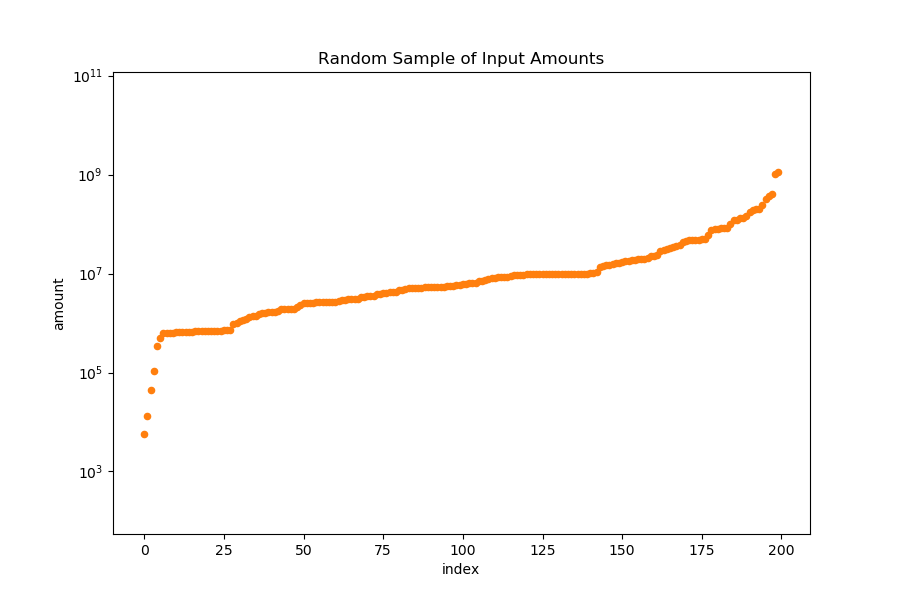

<IPython.core.display.Javascript object>


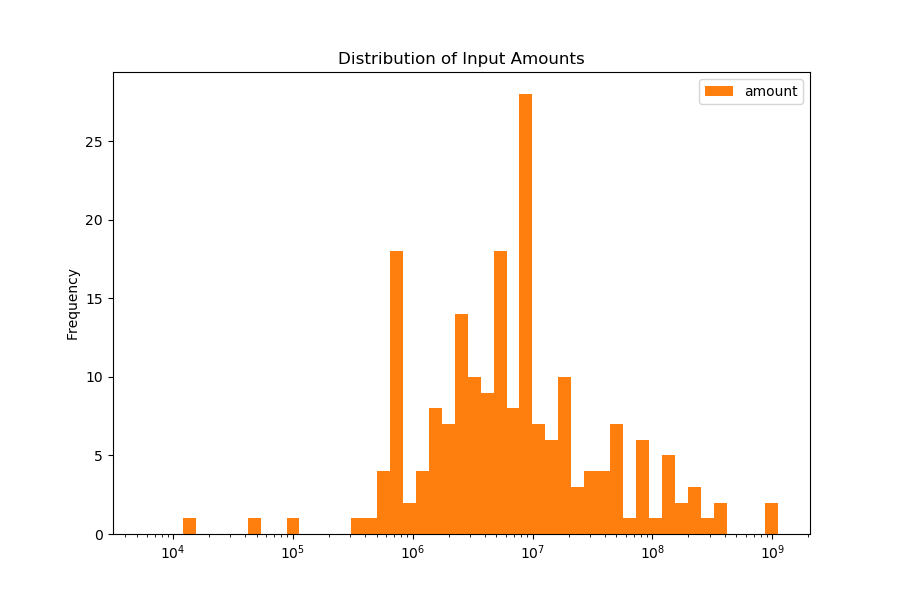

In [57]:
pd.DataFrame(sorted(inputs), columns=['amount']).reset_index().plot.scatter(x='index', y='amount', color='C1', logy=True, title="Random Sample of Input Amounts")
pd.DataFrame(inputs, columns=['amount']).plot.hist(bins=np.logspace(math.log10(min(inputs)),math.log10(max(inputs)),50), color='C1', logx=True, title="Distribution of Input Amounts")

### Deterministic Voting

The input amounts are known to all clients but the combined input clusters, which determine the balance that a user will split, are only known to their owners.

Users can try guess which denominations are most likely to be used as outputs in a transaction, base on just the individual amounts. If they are confident in their guess, then the rational behaviour if trying to maximize privacy is to try and pick denominations that other users are likely to also pick.

If we further suppose that all users suppose that all other users are guessing, and they take that into account in their guesses, we can avoid needing an infinite number of guesses if everybody assumes everyone's guesses will converge somehow. If this guessing leads to a Pareto efficient outcome then self interested users maximizing their privacy should not defect from the strategy of preferring to use the denominations that everyone is guessing everyone would prefer.

Of course, all of this must happen automatically as part of a distributed protocol where tens or even hundreds of users might all need to execute the protocol successfully so we need to automate this guesswork, and the automation must be efficient enough to not present a bottleneck.

One way to go about this is to evaluate some kind of social preference function. One possiblity is to simulate a vote where each input casts votes in proportion to its satoshi value and the votes are cast on the denominations that would favor that input.

1. decompose every input deterministically in a number of ways (e.g. greedy strategy with a number of subsets of standard denominations)
2. for every solution votes for the denominations its composed out of, dividing the input amount by the weight of the solution
3. tally the votes of all inputs to select some subset of "winning" denominations

If everyone simulates the same vote and then decomposes their amounts using only the "winning" denominations the likelyhood that too many denominations will be used in smaller transactions is greatly reduced, depending on how many winners there are.

This could conceivably be enforced by the coordinator (for example maybe only some amounts are allowed to be registered at first before other denominations or arbitrary values get "unlocked" in a round) or be completely advisory, where the coordinator just provides clients with the information. Input registrations are verifiable based on the ownership proofs, and output registrations can be verified after the fact before signing.

#### Voting System

In order to compute the results, a specific protocol must be chosen. It seems some sort of cardinal voting system would be best suited, but more thought to the specific approach should be given. 

This is "soft fork"-ish territory, because different voting strategies may fragment the userbase.

Different voting systems have [various properties](https://en.wikipedia.org/wiki/Comparison_of_electoral_systems), some of which may be more appropriate for this particular use case. If large inputs get more votes a proportional system can ensure smaller inputs are also represented, but too much representation may lead to fragmentation.

A number of possibilities we might want to consider:

- [cumulative voting](https://en.wikipedia.org/wiki/Cumulative_voting) - relatively simple
- single transferrable vote
- sequential proportional approval voting
- reweighted range voting
- Phragmen
- [satisfaction approval voting](https://en.wikipedia.org/wiki/Satisfaction_approval_voting)
- [distributed voting](https://electowiki.org/wiki/Distributed_Voting)
- [borda count](https://en.wikipedia.org/wiki/Borda_count)
- [justified representation](https://drops.dagstuhl.de/opus/volltexte/2018/8417/)

Note that some cardinal/proportional voting systems are algorithmically infeasible, and every client would need to compute this at least once, possibly for every new input/output amount, so a reasonably efficient solution is called for especially if it appears that dynamic updates about registration lead to significantly better privacy or efficiency.

#### Incremental Updates

If the coordinator provides dynamic updates about output amounts that actually get registered then clients would be able to make infinitely better guesses about which denominations are likely to be used by other users. This implies either recomputing the election, or updating it.

Consequentially it would be preferrable to use some sort of tallying approach where updating the results can be done efficiently, and the vote results tend to be stable (irrelevant alternatives, monotonicity?).

### Interim Solution - Cumulative Voting

Cumulative voting is a very simplest approach, so that's what we will go with for now.

In [58]:
feerate = 1
dust_threshold = 1999

In [59]:
from typing import Counter
from itertools import chain, islice
from collections import Counter

def pvs_for_large_values(denoms):
    """
    filter out values above 1 BTC in the given set, substituting with values from the 1-2-5 series
    """
    return chain(filter(lambda x: x < 1e8, denoms), filter(lambda x: x >= 1e8, preferred_value_series))

# these are the different strategies whose outputs will be taken into account
# only deterministic strategies are permitted, and the various sets of denominations
# are represented equally in the different strategies
# by substituting large values with 1-2-5 values this is more strongly biased towards those values.
# is this OK or does this create some sort of problematic bias? how should it be corrected?
voting_strategies = (Greedy(values=pvs_for_large_values(powers_of_two)),
              Greedy(values=pvs_for_large_values(ternary)),
              Greedy(values=preferred_value_series),
              Greedy(values=pvs_for_large_values(powers_of_two + ternary)),
              Greedy(values=pvs_for_large_values(powers_of_two + preferred_value_series)),
              Greedy(values=pvs_for_large_values(ternary + preferred_value_series)),
              Greedy(values=std_denoms), # same as pvs_for_large_values(powers_of_two + ternary + preferred_value_series)
              #Greedy(values=fibs),
             )

def decompose_deterministically(amount : int, feerate : int, dust_threshold : int, weight = None) -> Counter:
    if weight is None:
        weight = amount

    # map coins to regular ints, since we care about the number value not a distinct coin being created as an output
    solutions = [ list(map(int, strategy.decompose(amount, feerate, dust_threshold))) for strategy in voting_strategies]
    return sum([ Counter({ denom: int(weight/len(solution)) for denom in solution }) for solution in solutions ], start=Counter())

In [60]:
def plot_standardized_scores(counts : Counter, color='C2', title=None):
    count_df = pd.DataFrame(counts.most_common(), columns=['denom', 'count'])
    
    fig, ax = plt.subplots()
    count_df.plot.scatter(x='denom', y='count', ax=ax, logx=True, color=color, title=title)

    avg = count_df['count'].mean()
    std = count_df['count'].std()
    
    secax = ax.secondary_yaxis('right', functions=(lambda x: (x - avg) / std, lambda x: (x*std) + avg ))
    secax.set_ylabel('standard units')
    plt.show()

Let's begin by tallying the votes cast by each input separately. For the weight we further scale the amount by the number of inputs in the transactions, because for `n` inputs, there are `n` times as many pairs of inputs, which we will take into consideration in the next step, and it's easier to keep things deterministic when working with integers.

<IPython.core.display.Javascript object>


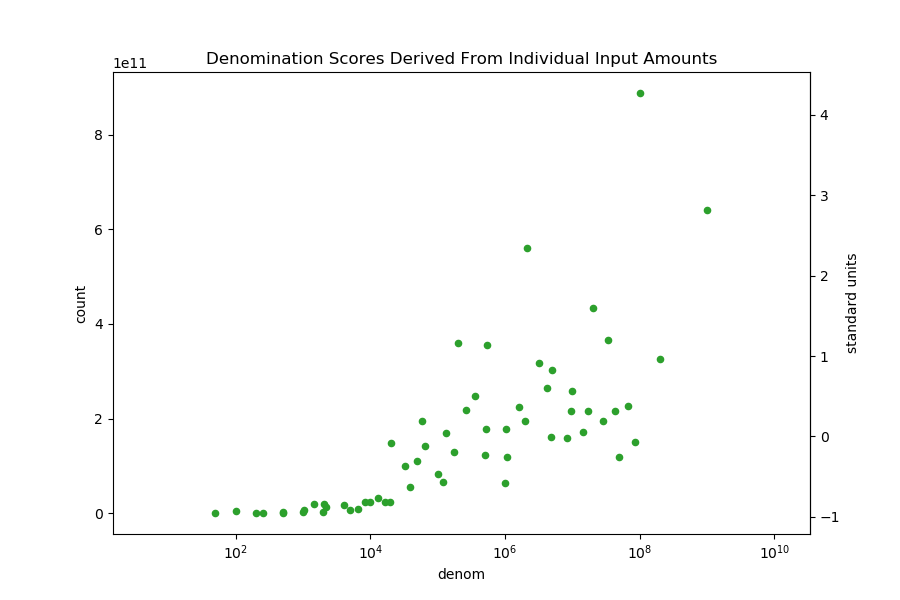

1.0 10.0 0.02097152 0.2 0.33554432 0.002 0.00531441 2.0 0.03188646 0.05 ...


In [61]:
counts : Counter = sum((decompose_deterministically(int(coin), feerate=feerate, dust_threshold=dust_threshold, weight=(int(coin) * len(inputs))) for coin in inputs), start=Counter())
plot_standardized_scores(counts, title="Denomination Scores Derived From Individual Input Amounts")
print(*(x[0]/1e8 for x in counts.most_common()[:10]), "...")

A more elaborate scheme involves taking all input-input pairs, and if outputs are known, also output-output pairs, and input-output pairs, and decomposing the absolute values of the sums and differences of these pairs where output amounts are considered negative. We could go further, but pairs is enough work for larger transactions.

Let's look at pairs of just inputs, since that's what we have for now. We will decompose both the sums of the pairs and their differences.

The goal of counting sums is to allow consolidation to be on average as cheap as mixing coins separately. If we assume only single input decompositions this will lead to higher fan-out than necessary.

The goal of counting differences of inputs is that each difference whose decomposition is represented by some subset of the outputs implies that a non-derived sub-transaction for the smaller of the two inputs is equivalent to a non-derived sub-transaction for the larger of the two with the additional standard denomination outputs.

In [62]:
from itertools import combinations

sum_counts : Counter = sum((decompose_deterministically(a+b, feerate=feerate, dust_threshold=dust_threshold) for (a,b) in combinations(inputs, 2)), start=Counter())

difference_counts : Counter = sum((decompose_deterministically(abs(a-b), feerate=feerate, dust_threshold=dust_threshold, weight=a+b) for (a,b) in combinations(inputs, 2)), start=Counter())

<IPython.core.display.Javascript object>


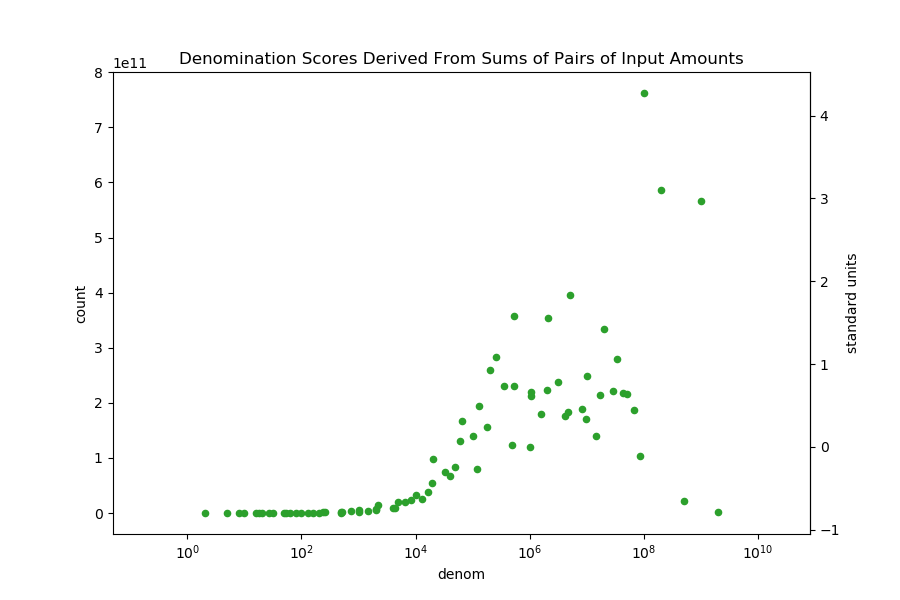

1.0 2.0 10.0 0.05 0.00531441 0.02097152 0.2 0.00262144 0.33554432 0.002 ...


<IPython.core.display.Javascript object>


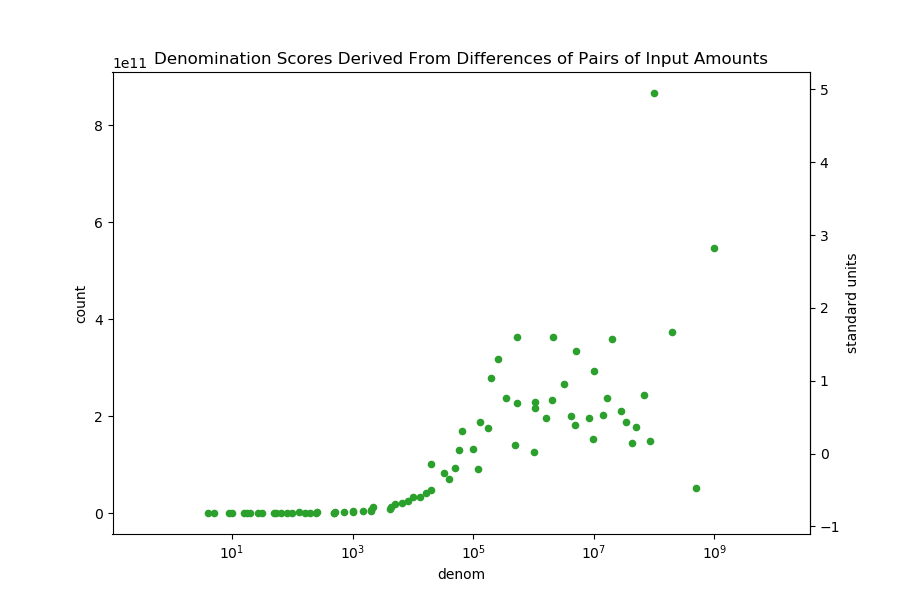

1.0 10.0 2.0 0.00531441 0.02097152 0.2 0.05 0.00262144 0.1 0.002 ...


In [63]:
plot_standardized_scores(sum_counts, title="Denomination Scores Derived From Sums of Pairs of Input Amounts")
print(*(x[0]/1e8 for x in sum_counts.most_common()[:10]), "...")

plot_standardized_scores(difference_counts, title="Denomination Scores Derived From Differences of Pairs of Input Amounts")
print(*(x[0]/1e8 for x in difference_counts.most_common()[:10]), "...")

Let's combine the results of all of the above. We can just sum everything together, since we only care about the relative ratios.

<IPython.core.display.Javascript object>


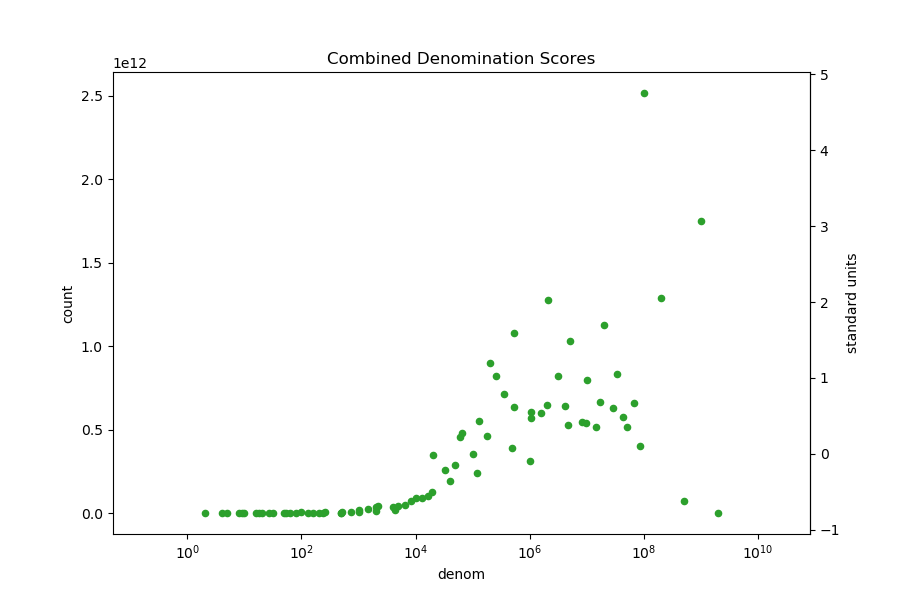

1.0 10.0 2.0 0.02097152 0.2 0.00531441 0.05 0.002 0.33554432 0.03188646 ...


In [64]:
combined = counts + sum_counts + difference_counts
plot_standardized_scores(combined, title="Combined Denomination Scores")
print(*(x[0]/1e8 for x in combined.most_common()[:10]), "...")

### Computing Vote Results

Based on these counts we can pick our "winning" denominations.

The set of winners should ideally should be chosen so that they are nicely spaced, and the number of winners should be based on the size of the transaction and the variance of its input amounts. It should also be monotone in the case of dynamic updates about new registration amounts.

Pending further investigations on how to best approach this, for now we will just go with a some number of top `n` results, where `n` is for now derived with an ad-hoc formula based on the number of inputs.

In [65]:
number_of_winners = min(5+int(math.log(len(inputs))**2), len(combined))
number_of_winners

33

In [66]:
combined_winners = [ x[0] for x in combined.most_common()[:number_of_winners] ]
print(*(x/1e8 for x in sorted(combined_winners, reverse=True)))

10.0 2.0 1.0 0.86093442 0.67108864 0.5 0.43046721 0.33554432 0.28697814 0.2 0.16777216 0.14348907 0.1 0.09565938 0.08388608 0.05 0.04782969 0.04194304 0.03188646 0.02097152 0.02 0.01594323 0.01062882 0.01048576 0.00531441 0.00524288 0.00354294 0.00262144 0.002 0.00177147 0.00131072 0.00065536 0.00059049


By also including all smaller denominations (subject to the dust limit constraints) we allow more flexibility for the randomized strategies to come up with solutions that deviate more from the greedy ones without much risk, thereby suppressing the creation of higher Hamming weight amounts for remaining values when no small denominations are selected. Such amounts can reveal information about a user's input cluster as well as the amounts they used for its decomposition. Because the amounts are small the resulting fragmentation is not as problematic as with the larger amounts.

In [67]:
from itertools import chain

# allow all small denoms to always be used, subject to dust threshold limits
# TODO this magic number should be determined by the winning denominations
restricted_set = frozenset(chain(filter(lambda x: x <= 100000, std_denoms), combined_winners))

#### TODO

- How should the dust threshold be set in voting?
  - same value should be used by all in the calculation
  - should match hard dust threshold (e.g. if imposed by feerate)
  - should probably be some minimum denomination -1, e.g. 1999 or 1023
  - seems that setting to 0 spreads out the results too much

# Simulating a CoinJoin With "Winning" Amounts

Although individual inputs are not overtly linked they can still be combined by users, so let's simulate some clustering of inputs. The following roughly simulates the current client behaviour in Wasabi and may not be a good model of expected user behaviour for the newer protocol, so this assumption probably needs to be re-examined.

In [68]:
from collections import defaultdict

# TODO make into Coins
input_clusters = defaultdict(list)

# assign large amounts to random new users or existing users
for amount in filter(lambda x: x >= 0.95e7, inputs):
        input_clusters[random.randint(0, len(inputs))].append(amount)

# assign small amounts to existing users from the previous pass
users = list(input_clusters.keys())
for amount in filter(lambda x: x < 0.95e7, inputs):
        input_clusters[random.choice(users)].append(amount)

<IPython.core.display.Javascript object>


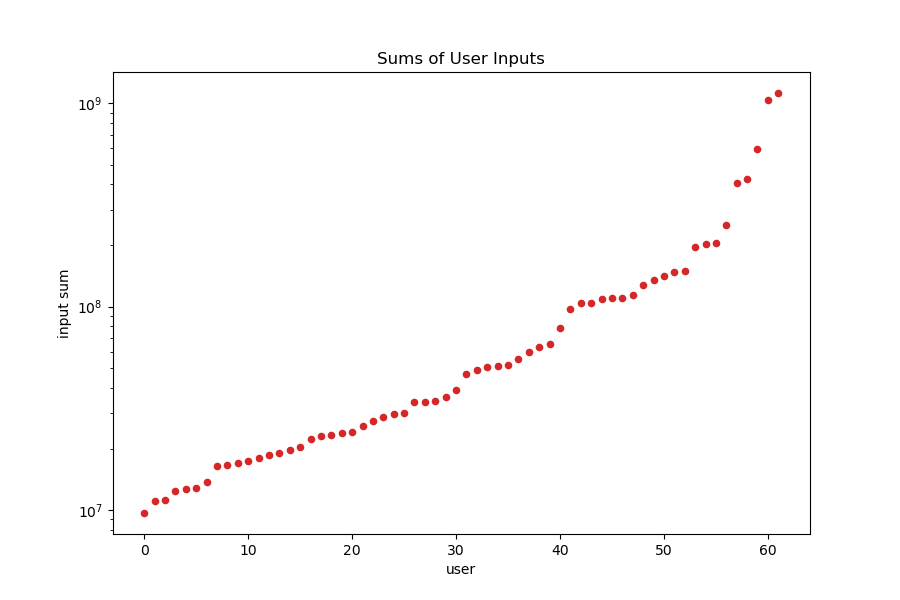

<IPython.core.display.Javascript object>


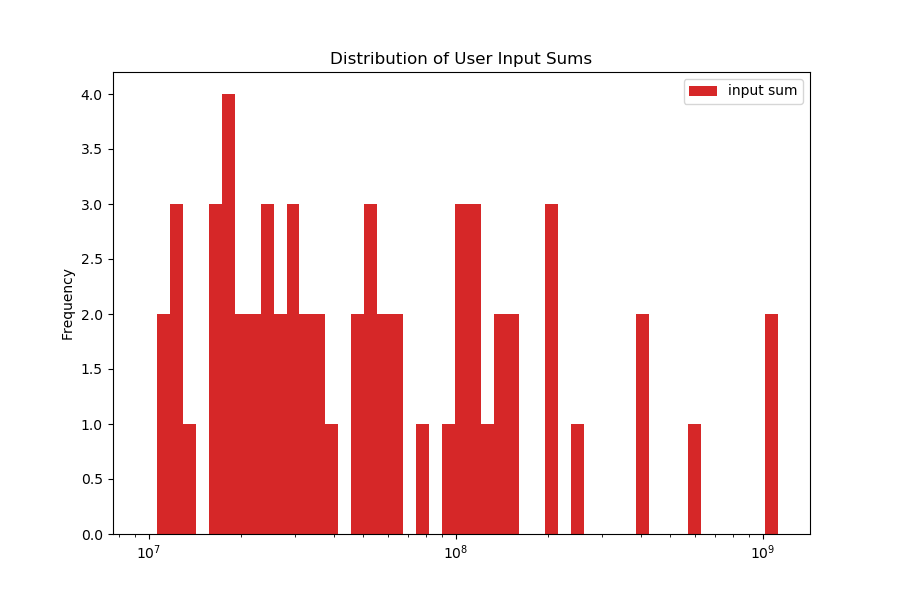

In [69]:
# TODO rename column to 'user' instead of just changing label
input_cluster_amounts = sorted([ sum(inputs) for (user, inputs) in input_clusters.items() ])
ax = pd.DataFrame(input_cluster_amounts, columns=['input sum']).reset_index().plot.scatter(x='index', y='input sum', color='C3', title="Sums of User Inputs")
ax.set_xlabel('user')
plt.yscale('log')

pd.DataFrame(input_cluster_amounts, columns=['input sum']).plot.hist(bins=np.logspace(math.log10(min(input_cluster_amounts)),math.log10(max(input_cluster_amounts)),50), color='C3', title="Distribution of User Input Sums")
plt.xscale('log')

We can again compare a few runs with different strategies, this time using our restricted set of values:

In [70]:
iters = 1000 # this is just a quick preview to compare the restricted sets from the individual input amounts with the regular ones on the combined input amounts

restricted_strategies = {
    "greedy (all)": Greedy(values=std_denoms),
    "greedy (only winners)": Greedy(values=combined_winners),
    "greedy (restricted)": Greedy(values=restricted_set),
    "stochastic (all)": BestOfN(n=iters, values=std_denoms),
    "annealing (all)": SimulatedAnnealing(n=iters, values=std_denoms, starting_temperature=1.0),
    "stochastic (restricted)": BestOfN(n=iters, values=restricted_set),
    "annealing (restricted)": SimulatedAnnealing(n=iters, values=restricted_set, starting_temperature=1.0),
}

# the feerate is fixed, but the dust threshold specified here can be 
# set by each user to accomodate their preferences, ideally from a
# constrained set of values so as to not overtly signal those preferences
feerate = 1
dust_threshold=4999

cluster_amounts = []
for cluster in input_clusters.values():
    amount = int(sum(cluster)) - int(feerate * len(cluster) * Coin(1).input_vbytes) # TODO round properly
    cluster_amounts.append(amount)
    
    print("Total input amount", amount/1e8, "from", len(cluster), "input(s)", cluster, "\n")
    
    for (name, strategy) in restricted_strategies.items():
        for _ in range(0, 1 if not isinstance(strategy, Stochastic) else 3):
            solution = strategy.decompose(amount, feerate=feerate, dust_threshold=dust_threshold)
            print("  ", name, sum(solution) - amount, "sats,", "fees:", len(solution), "=", feerate*solution.outputs_vbytes, sorted(solution, reverse=True))
    print("\n")

Total input amount 1.04077286 from 5 input(s) [84562993, 14515407, 3390076, 951231, 657921] 

   greedy (all) -2905 sats, fees: 4 = 124 [100000000, 3188646, 531441, 354294]
   greedy (only winners) -2905 sats, fees: 4 = 124 [100000000, 3188646, 531441, 354294]
   greedy (restricted) -2905 sats, fees: 4 = 124 [100000000, 3188646, 531441, 354294]
   stochastic (all) -2905 sats, fees: 4 = 124 [100000000, 3188646, 531441, 354294]
   stochastic (all) -2905 sats, fees: 4 = 124 [100000000, 3188646, 531441, 354294]
   stochastic (all) -2905 sats, fees: 4 = 124 [100000000, 3188646, 531441, 354294]
   annealing (all) -1470 sats, fees: 6 = 186 [50000000, 33554432, 20000000, 500000, 16384, 5000]
   annealing (all) -978 sats, fees: 6 = 186 [86093442, 16777216, 1062882, 100000, 32768, 10000]
   annealing (all) -2737 sats, fees: 6 = 186 [86093442, 9565938, 8388608, 10000, 10000, 6561]
   stochastic (restricted) -2905 sats, fees: 4 = 124 [100000000, 3188646, 531441, 354294]
   stochastic (restricted) 

   annealing (all) -2830 sats, fees: 4 = 124 [20000000, 2000000, 1000000, 19683]
   annealing (all) -1804 sats, fees: 7 = 217 [16777216, 4194304, 2000000, 19683, 16384, 6561, 6561]
   stochastic (restricted) -993 sats, fees: 4 = 124 [16777216, 4194304, 2000000, 50000]
   stochastic (restricted) -2854 sats, fees: 4 = 124 [14348907, 8388608, 262144, 20000]
   stochastic (restricted) -993 sats, fees: 4 = 124 [16777216, 4194304, 2000000, 50000]
   annealing (restricted) -1470 sats, fees: 5 = 155 [14348907, 8388608, 262144, 16384, 5000]
   annealing (restricted) -1470 sats, fees: 5 = 155 [14348907, 8388608, 262144, 16384, 5000]
   annealing (restricted) -1186 sats, fees: 9 = 279 [14348907, 8388608, 131072, 65536, 32768, 20000, 19683, 8192, 6561]


Total input amount 0.490093 from 7 input(s) [9852324, 16639409, 17771800, 44362, 1321000, 2686174, 694710] 

   greedy (all) -1308 sats, fees: 6 = 186 [43046721, 5000000, 531441, 354294, 65536, 10000]
   greedy (only winners) -186 sats, fees: 6 = 

   stochastic (all) -3619 sats, fees: 5 = 155 [86093442, 50000000, 4782969, 177147, 8192]
   stochastic (all) -319 sats, fees: 5 = 155 [86093442, 33554432, 20000000, 1062882, 354294]
   stochastic (all) -1790 sats, fees: 5 = 155 [67108864, 67108864, 4782969, 1062882, 1000000]
   annealing (all) -4909 sats, fees: 10 = 310 [86093442, 50000000, 4782969, 100000, 20000, 19683, 13122, 13122, 13122, 5000]
   annealing (all) -5305 sats, fees: 9 = 279 [86093442, 50000000, 4194304, 354294, 200000, 100000, 65536, 39366, 13122]
   annealing (all) -2136 sats, fees: 7 = 217 [86093442, 50000000, 4782969, 131072, 19683, 19683, 16384]
   stochastic (restricted) -2487 sats, fees: 4 = 124 [100000000, 20000000, 20000000, 1062882]
   stochastic (restricted) -2487 sats, fees: 4 = 124 [100000000, 20000000, 20000000, 1062882]
   stochastic (restricted) -2487 sats, fees: 4 = 124 [100000000, 20000000, 20000000, 1062882]
   annealing (restricted) -3597 sats, fees: 9 = 279 [100000000, 20000000, 20000000, 524288, 

   stochastic (all) -1450 sats, fees: 4 = 124 [20000000, 8388608, 118098, 8192]
   annealing (all) -3081 sats, fees: 4 = 124 [20000000, 8388608, 118098, 6561]
   annealing (all) -3081 sats, fees: 4 = 124 [20000000, 8388608, 118098, 6561]
   annealing (all) -3081 sats, fees: 4 = 124 [20000000, 8388608, 118098, 6561]
   stochastic (restricted) -3155 sats, fees: 4 = 124 [20000000, 8388608, 65536, 59049]
   stochastic (restricted) -3155 sats, fees: 4 = 124 [20000000, 8388608, 65536, 59049]
   stochastic (restricted) -3155 sats, fees: 4 = 124 [20000000, 8388608, 65536, 59049]
   annealing (restricted) -3164 sats, fees: 5 = 155 [20000000, 8388608, 100000, 16384, 8192]
   annealing (restricted) -4795 sats, fees: 5 = 155 [20000000, 8388608, 100000, 16384, 6561]
   annealing (restricted) -2740 sats, fees: 5 = 155 [20000000, 8388608, 100000, 20000, 5000]


Total input amount 0.1898927 from 4 input(s) [10000000, 3046397, 5279929, 663218] 

   greedy (all) -1780 sats, fees: 4 = 124 [16777216, 2097

   annealing (restricted) -5166 sats, fees: 9 = 279 [200000000, 200000000, 16777216, 4194304, 2000000, 524288, 50000, 19683, 6561]
   annealing (restricted) -1333 sats, fees: 8 = 248 [200000000, 200000000, 20000000, 3188646, 354294, 16384, 10000, 6561]
   annealing (restricted) -3483 sats, fees: 9 = 279 [200000000, 200000000, 20000000, 3188646, 131072, 131072, 100000, 16384, 6561]


Total input amount 2.05015415 from 3 input(s) [199994528, 4310344, 710748] 

   greedy (all) -2293 sats, fees: 3 = 93 [200000000, 5000000, 13122]
   greedy (only winners) -93 sats, fees: 3 = 93 [200000000, 5000000, 15322]
   greedy (restricted) -2293 sats, fees: 3 = 93 [200000000, 5000000, 13122]
   stochastic (all) -2293 sats, fees: 3 = 93 [200000000, 5000000, 13122]
   stochastic (all) -2293 sats, fees: 3 = 93 [200000000, 5000000, 13122]
   stochastic (all) -2293 sats, fees: 3 = 93 [200000000, 5000000, 13122]
   annealing (all) -2293 sats, fees: 3 = 93 [200000000, 5000000, 13122]
   annealing (all) -2293 

   annealing (restricted) -269 sats, fees: 3 = 93 [14348907, 2097152, 10000]


Total input amount 0.29528318 from 3 input(s) [20362868, 8546488, 619167] 

   greedy (all) -4151 sats, fees: 4 = 124 [28697814, 531441, 262144, 32768]
   greedy (only winners) -124 sats, fees: 4 = 124 [28697814, 531441, 262144, 36795]
   greedy (restricted) -4151 sats, fees: 4 = 124 [28697814, 531441, 262144, 32768]
   stochastic (all) -2264 sats, fees: 4 = 124 [14348907, 10000000, 5000000, 177147]
   stochastic (all) -2264 sats, fees: 4 = 124 [14348907, 10000000, 5000000, 177147]
   stochastic (all) -2824 sats, fees: 4 = 124 [28697814, 500000, 262144, 65536]
   annealing (all) -2077 sats, fees: 5 = 155 [20000000, 8388608, 1000000, 131072, 6561]
   annealing (all) -808 sats, fees: 7 = 217 [20000000, 8388608, 1048576, 39366, 32768, 10000, 8192]
   annealing (all) -584 sats, fees: 6 = 186 [20000000, 8388608, 1062882, 50000, 19683, 6561]
   stochastic (restricted) -4706 sats, fees: 4 = 124 [28697814, 524288, 2

   stochastic (all) -2482 sats, fees: 5 = 155 [67108864, 67108864, 9565938, 4194304, 2000000]
   stochastic (all) -3610 sats, fees: 5 = 155 [100000000, 43046721, 4782969, 2097152, 50000]
   annealing (all) -1248 sats, fees: 8 = 248 [86093442, 43046721, 20000000, 524288, 200000, 100000, 8192, 6561]
   annealing (all) -2018 sats, fees: 9 = 279 [86093442, 43046721, 20000000, 531441, 177147, 100000, 13122, 10000, 6561]
   annealing (all) -3983 sats, fees: 8 = 248 [86093442, 43046721, 20000000, 531441, 200000, 65536, 32768, 6561]
   stochastic (restricted) -3610 sats, fees: 5 = 155 [100000000, 43046721, 4782969, 2097152, 50000]
   stochastic (restricted) -1075 sats, fees: 5 = 155 [86093442, 33554432, 28697814, 1594323, 39366]
   stochastic (restricted) -3610 sats, fees: 5 = 155 [100000000, 43046721, 4782969, 2097152, 50000]
   annealing (restricted) -567 sats, fees: 11 = 341 [86093442, 43046721, 20000000, 354294, 262144, 177147, 16384, 10000, 8192, 6561, 5000]
   annealing (restricted) -518

   annealing (restricted) -201 sats, fees: 5 = 155 [16777216, 3188646, 354294, 5000, 5000]


Total input amount 0.51733768 from 3 input(s) [38071417, 5098304, 8564252] 

   greedy (all) -181 sats, fees: 4 = 124 [50000000, 1594323, 131072, 8192]
   greedy (only winners) -124 sats, fees: 4 = 124 [50000000, 1594323, 131072, 8249]
   greedy (restricted) -181 sats, fees: 4 = 124 [50000000, 1594323, 131072, 8192]
   stochastic (all) -3194 sats, fees: 4 = 124 [43046721, 8388608, 177147, 118098]
   stochastic (all) -3194 sats, fees: 4 = 124 [43046721, 8388608, 177147, 118098]
   stochastic (all) -3194 sats, fees: 4 = 124 [43046721, 8388608, 177147, 118098]
   annealing (all) -3373 sats, fees: 4 = 124 [50000000, 1594323, 131072, 5000]
   annealing (all) -1594 sats, fees: 6 = 186 [50000000, 1594323, 118098, 8192, 6561, 5000]
   annealing (all) -3373 sats, fees: 4 = 124 [50000000, 1594323, 131072, 5000]
   stochastic (restricted) -1812 sats, fees: 4 = 124 [50000000, 1594323, 131072, 6561]
   stoc

   stochastic (all) -960 sats, fees: 3 = 93 [20000000, 4194304, 50000]
   stochastic (all) -960 sats, fees: 3 = 93 [20000000, 4194304, 50000]
   annealing (all) -5033 sats, fees: 4 = 124 [20000000, 4194304, 39366, 6561]
   annealing (all) -960 sats, fees: 3 = 93 [20000000, 4194304, 50000]
   annealing (all) -960 sats, fees: 3 = 93 [20000000, 4194304, 50000]
   stochastic (restricted) -960 sats, fees: 3 = 93 [20000000, 4194304, 50000]
   stochastic (restricted) -960 sats, fees: 3 = 93 [20000000, 4194304, 50000]
   stochastic (restricted) -960 sats, fees: 3 = 93 [20000000, 4194304, 50000]
   annealing (restricted) -5070 sats, fees: 4 = 124 [20000000, 4194304, 32768, 13122]
   annealing (restricted) -960 sats, fees: 3 = 93 [20000000, 4194304, 50000]
   annealing (restricted) -1481 sats, fees: 4 = 124 [20000000, 3188646, 1048576, 6561]


Total input amount 0.34016249 from 2 input(s) [29291591, 4724795] 

   greedy (all) -962 sats, fees: 4 = 124 [33554432, 354294, 100000, 6561]
   greedy (o

   stochastic (all) -1614 sats, fees: 5 = 155 [200000000, 200000000, 5000000, 1048576, 118098]
   stochastic (all) -1614 sats, fees: 5 = 155 [200000000, 200000000, 5000000, 1048576, 118098]
   annealing (all) -5166 sats, fees: 7 = 217 [200000000, 200000000, 5000000, 1000000, 100000, 50000, 13122]
   annealing (all) -1309 sats, fees: 10 = 310 [200000000, 200000000, 5000000, 531441, 354294, 200000, 50000, 19683, 6561, 5000]
   annealing (all) -4712 sats, fees: 7 = 217 [200000000, 200000000, 5000000, 1048576, 100000, 10000, 5000]
   stochastic (restricted) -1244 sats, fees: 6 = 186 [200000000, 200000000, 4782969, 1062882, 262144, 59049]
   stochastic (restricted) -4846 sats, fees: 6 = 186 [200000000, 100000000, 86093442, 20000000, 50000, 20000]
   stochastic (restricted) -2514 sats, fees: 6 = 186 [200000000, 200000000, 4194304, 1594323, 200000, 177147]
   annealing (restricted) -4102 sats, fees: 7 = 217 [200000000, 200000000, 5000000, 1048576, 59049, 50000, 6561]
   annealing (restricted)

   stochastic (all) -1890 sats, fees: 4 = 124 [8388608, 5000000, 2097152, 1048576]
   annealing (all) -4948 sats, fees: 5 = 155 [14348907, 2097152, 65536, 13122, 6561]
   annealing (all) -3611 sats, fees: 4 = 124 [14348907, 2000000, 177147, 6561]
   annealing (all) -2506 sats, fees: 4 = 124 [14348907, 1594323, 531441, 59049]
   stochastic (restricted) -801 sats, fees: 4 = 124 [14348907, 2097152, 50000, 39366]
   stochastic (restricted) -1890 sats, fees: 4 = 124 [8388608, 5000000, 2097152, 1048576]
   stochastic (restricted) -3611 sats, fees: 4 = 124 [14348907, 2000000, 177147, 6561]
   annealing (restricted) -3611 sats, fees: 4 = 124 [14348907, 2000000, 177147, 6561]
   annealing (restricted) -3611 sats, fees: 4 = 124 [14348907, 2000000, 177147, 6561]
   annealing (restricted) -172 sats, fees: 4 = 124 [14348907, 2000000, 177147, 10000]


Total input amount 0.12765086 from 3 input(s) [9800000, 1879341, 1085950] 

   greedy (all) -421 sats, fees: 5 = 155 [10000000, 2097152, 531441, 13107

Here is a plot of the same (note stochastic results will vary from the previous cell).

<IPython.core.display.Javascript object>


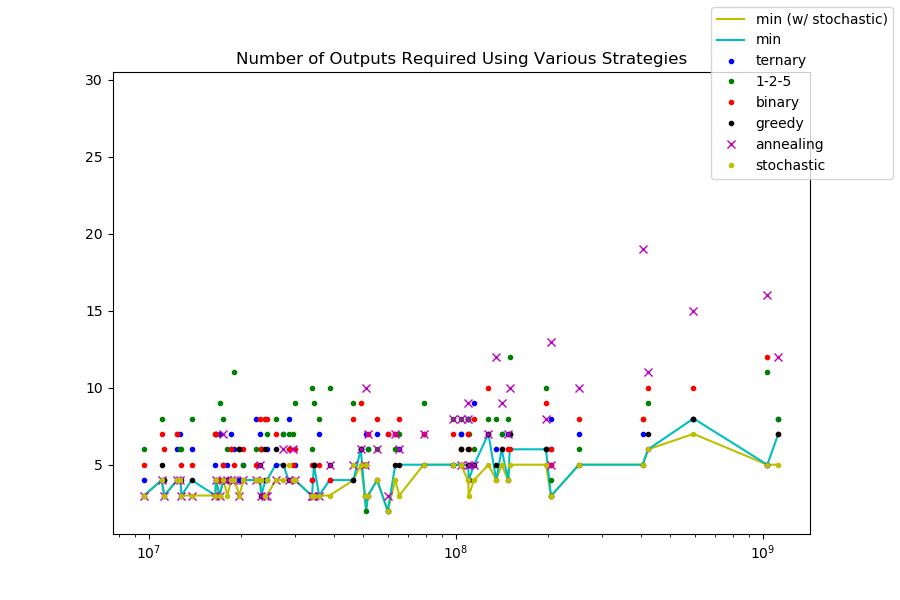

In [71]:
# TODO refactor interactivity with functools.partial?
iters = 5000 # this time let's try a bit harder
(greedy, stochastic, annealing) = plot_amount_decompositions(sorted(cluster_amounts), dust_threshold, feerate, iters, iters, 1.0, 0, False, True, True, restricted_set)

So we've simulated a possible CoinJoin transaction.

In [72]:
from functools import partial

cheapest_outputs = list(map(partial(min,key=len),zip(greedy, stochastic, annealing)))
attributed_tx = tuple(zip(sorted(map(tuple, input_clusters.values()), key=sum), cheapest_outputs))

To get an idea for the value distribution, here is a plot of the input and output amounts sorted separately so that individual users' outputs are not grouped, and although x axis is not related between the two sets of points (amounts are just sorted by value) The slopes do tell us something about the fragmentation outcomes of our transaction:

<IPython.core.display.Javascript object>


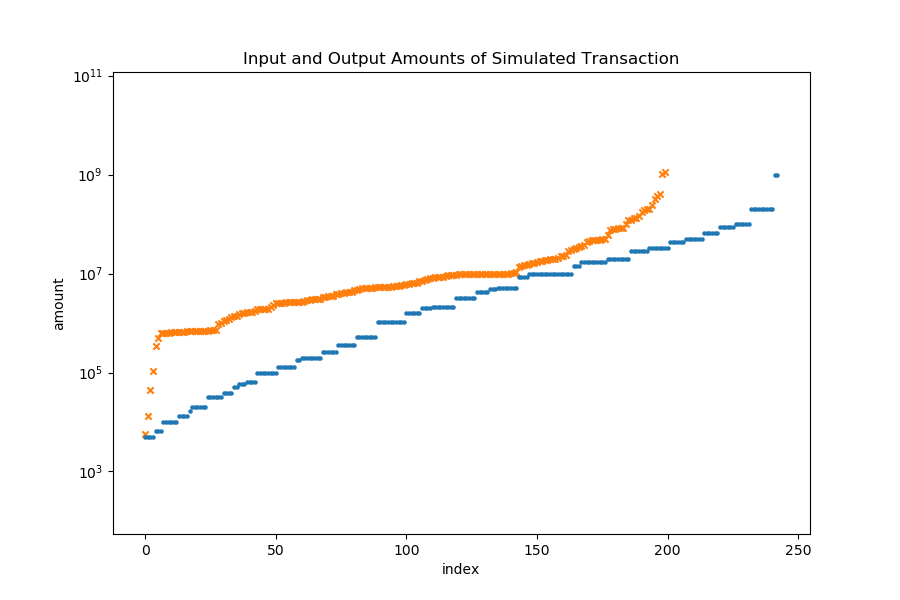

Text(0, 0.5, 'amount')

In [73]:
ax = pd.DataFrame(sorted(chain(*(map(lambda x: x[0], attributed_tx)))), columns=['input amount']).reset_index().plot.scatter(x='index', y='input amount', logy=True, c='C1',marker='x', title="Input and Output Amounts of Simulated Transaction")
pd.DataFrame(sorted(chain(*(map(lambda x: x[1], attributed_tx)))), columns=['output amount']).reset_index().plot.scatter(x='index', y='output amount', logy=True, c='C0', marker='.', ax=ax)
ax.set_ylabel("amount")

And naturally we also would like to see how many instances there were of each output value:

In [74]:
from itertools import chain

denom_counts = Counter(map(int, chain(*cheapest_outputs)))

for denom in sorted(denom_counts.keys(), reverse=True):
    print(denom, denom_counts[denom], '!' if denom_counts[denom] == 1 else '')

1000000000 2 
200000000 9 
100000000 6 
86093442 6 
67108864 6 
50000000 7 
43046721 6 
33554432 8 
28697814 7 
20000000 9 
16777216 10 
14348907 3 
10000000 6 
9565938 11 
8388608 4 
5000000 8 
4782969 3 
4194304 5 
3188646 8 
2097152 9 
2000000 4 
1594323 6 
1062882 7 
1048576 4 
531441 7 
524288 1 !
354294 7 
262144 6 
200000 8 
177147 2 
131072 7 
100000 8 
65536 4 
59049 3 
50000 2 
39366 4 
32768 6 
20000 5 
19683 1 !
16384 1 !
13122 4 
10000 6 
6561 3 
5000 4 


<IPython.core.display.Javascript object>


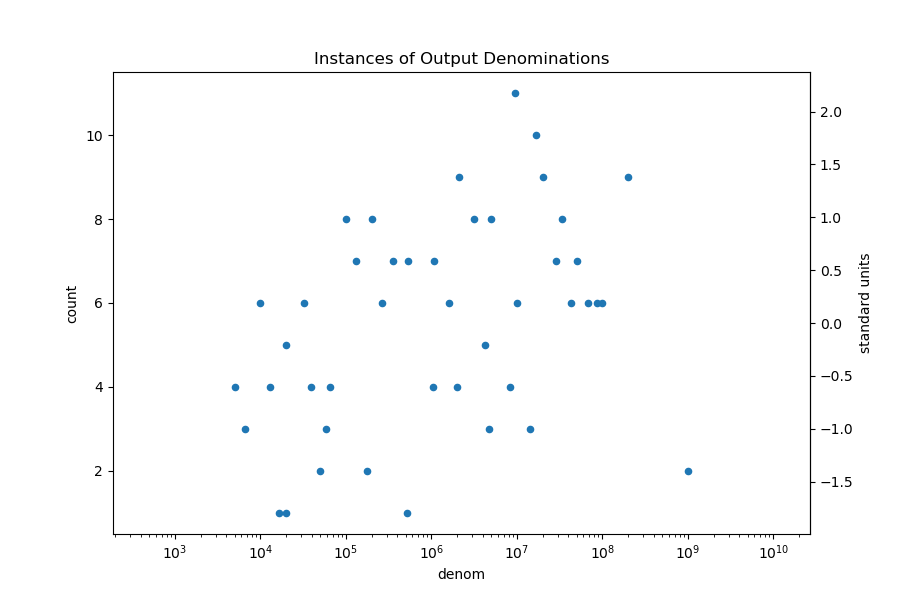

<IPython.core.display.Javascript object>


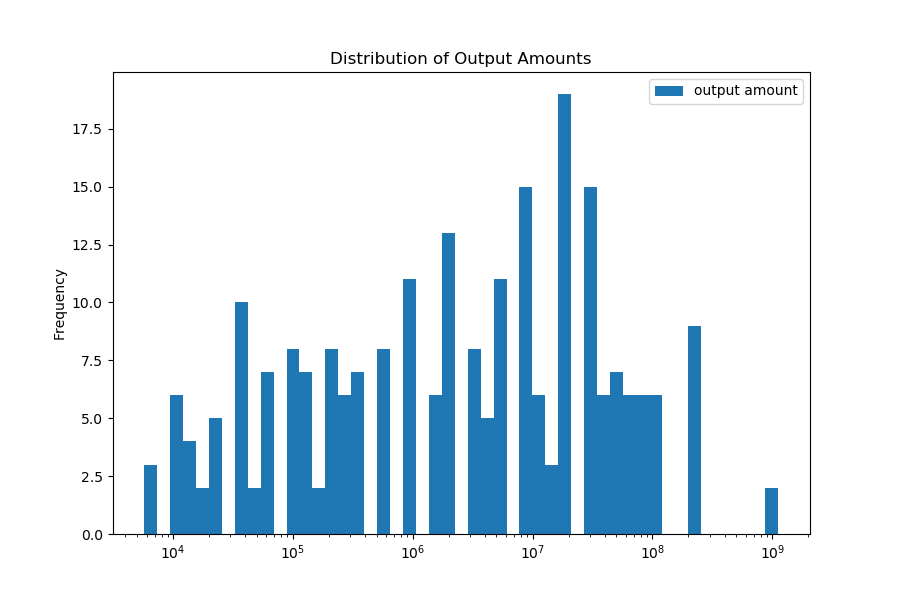

In [75]:
plot_standardized_scores(denom_counts, color='C0', title="Instances of Output Denominations")

pd.DataFrame(sorted(chain(*(map(lambda x: x[1], attributed_tx)))), columns=['output amount']).plot.hist(bins=np.logspace(math.log10(min(inputs)),math.log10(max(inputs)),50), color='C0', logx=True, title="Distribution of Output Amounts")

Since we know what our simulated users did, we can show the mapping of inputs to outputs in the transaction. Every pair in the following represents the actual sub-transaction, a mapping from an n-tuple of inputs to an n-tuple of outputs (but think of them as an unordered sets):

In [76]:
print("number of users", len(attributed_tx))
print("number of inputs", sum(map(len, map(lambda x: x[0], attributed_tx))))
print("number of outputs", sum(map(len, map(lambda x: x[1], attributed_tx))))

attributed_tx

number of users 62
number of inputs 200
number of outputs 243


(((9651528,), (9565938, 65536, 16384)),
 ((10500000, 496260), (9565938, 1048576, 177147, 200000)),
 ((9834203, 1388571), (9565938, 1594323, 59049)),
 ((9800000, 2569834), (10000000, 2097152, 262144, 5000)),
 ((10000000, 2672650), (10000000, 2097152, 531441, 39366)),
 ((9800000, 1879341, 1085950), (9565938, 3188646, 6561)),
 ((9784436, 4000000), (9565938, 4194304, 20000)),
 ((10297856, 1158677, 5000000), (14348907, 2097152, 6561)),
 ((13856859, 2679504), (14348907, 2097152, 65536, 20000)),
 ((9855000, 709041, 666260, 3819741, 1944999), (16777216, 200000, 13122)),
 ((17480852,), (16777216, 531441, 131072, 32768)),
 ((18029597,), (16777216, 1048576, 200000)),
 ((15000000, 13349, 3500770), (16777216, 1594323, 131072, 6561)),
 ((10000000, 3046397, 5279929, 663218), (16777216, 2097152, 100000, 10000)),
 ((19000000, 703223), (10000000, 9565938, 131072)),
 ((15526717, 1643535, 2490000, 670379), (20000000, 262144, 59049, 5000)),
 ((22316384,), (20000000, 2097152, 200000, 13122)),
 ((9855000, 64

We can plot this mapping, but we'll need to plot it twice to see different aspects. In both following plots:

- inputs and outputs of a single user are vertically aligned
- inputs and outputs of the same amount are horizontally aligned

In the log scale plot, we can get a better sense for the combinatorics of equivalent sub-transactions:
 
- individual inputs and outputs are well represented
- if input-input links are known the permutations of each output equivalence class defines `(n-1)!` equivalent non-derived sub-transactions for any non-derived sub-transaction intersecting with the equivalence class
- otherwise users' balances are themselves ambiguous, resulting in significantly more possible combianations

Then in the linear scale plot we can better see the relationships between the larger amounts:

- similar magnitude points are vertically compressed, but proportions are preserved shows where liquidity is concentrated
- evenly spaced amounts belonging to different users indicate equivalence relations generated from substitutable combinations (e.g. `.5 + .5 = 1.0 + ϵ`

In [77]:
# generate pairs of (user index, amount) and flatten into a table in 1st normal form
inputs_by_user = pd.DataFrame(chain(*[ [ (i, x) for x in attributed_tx[i][0] ] for i in range(0, len(attributed_tx)) ]), columns=['user', 'input amount'])
outputs_by_user = pd.DataFrame(chain(*[ [ (i, x) for x in attributed_tx[i][1] ] for i in range(0, len(attributed_tx)) ]), columns=['user', 'output amount'])

<IPython.core.display.Javascript object>


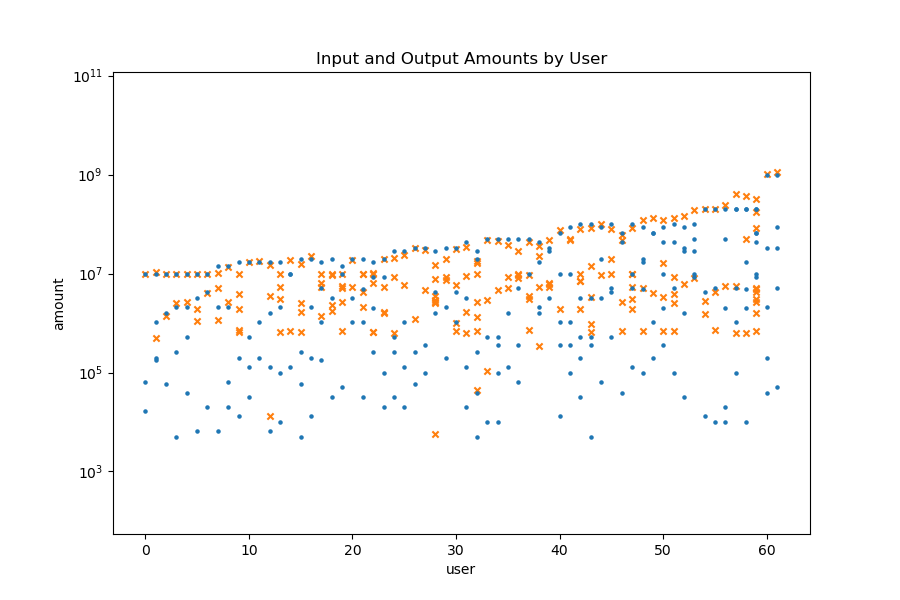

<IPython.core.display.Javascript object>


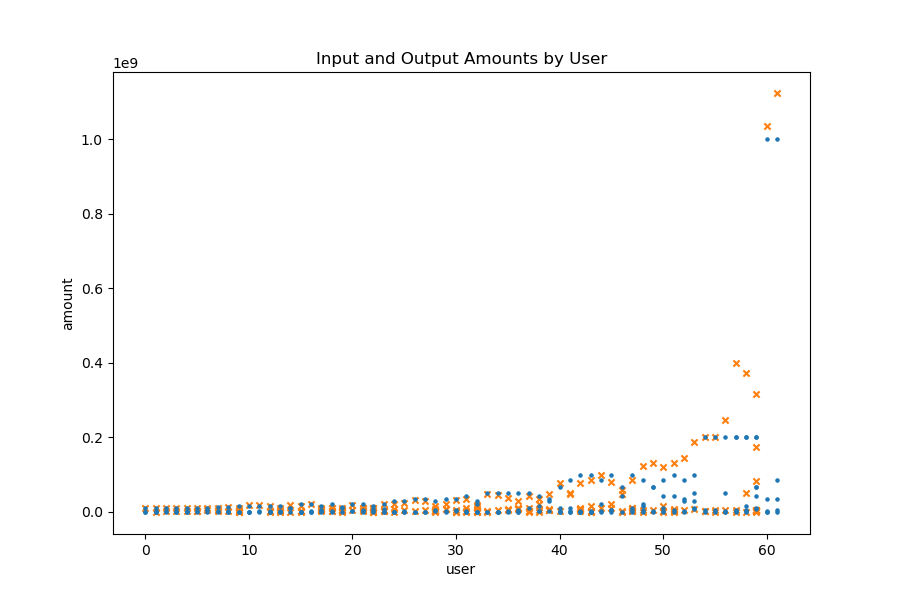

In [78]:
# TODO legend
# .merge and then .melt(id_vars=['user'], value_vars=['input amount', 'output amount'])?
# how to plot the resulting categorical var as marker/color?

for logy in (True, False):
    ax = inputs_by_user.plot.scatter(x='user', y='input amount', logy=logy, c='C1', marker='x', title="Input and Output Amounts by User")
    outputs_by_user.plot.scatter(x='user', y='output amount', logy=logy, c='C0', marker='.', ax=ax)
    ax.set_ylabel('amount')